# Generating Dog Images Based on Their Breed with Conditional VAE

## Problem Statement

How can we generate realistic images of dogs conditioned on their breed? The goal of this project is to explore generative modeling techniques to tackle this challenge, focusing on the Conditional Variational Autoencoder (C-VAE) as a solution. By conditioning the generative process on breed labels, we aim to create diverse, breed-specific dog images.

This problem is not only a fun application of machine learning but also provides insight into how conditional generative models work in practice. Such techniques can be extended to broader domains, such as conditional image synthesis, data augmentation, and even artistic applications.

# Proposed Solution

To solve this problem, I implemented a Conditional Variational Autoencoder (C-VAE), a generative model that learns to reconstruct and generate images based on a specific condition (dog breeds). The architecture consists of:
1. Encoder: Compresses input images into a latent space representation, capturing essential features of the image while incorporating breed-specific conditioning.
2. Reparameterization: Enables stochastic sampling of latent vectors, ensuring smooth latent space interpolation and diverse generations.
3. Decoder: Reconstructs the image from the conditioned latent vector, generating breed-specific outputs.

Despite the challenges of generating high-quality images due to dataset and architecture constraints, the project highlights the intuition gained from the latent space about dog breeds (e.g., features like nose or color patterns).

## How the Model Works

Conditional VAE Architecture Overview
1. Encoder: Extracts hierarchical features using convolutional layers, residual connections, and pooling to output the mean (mu) and log-variance (logvar) of the latent space.
2. Reparameterization Trick: Samples latent vectors  z  using:\
   $z = \mu + \epsilon \cdot \sigma \quad (\epsilon \sim \mathcal{N}(0, I))$ \
   This allows the model to learn a smooth and meaningful latent space.
4. Conditioning: Incorporates breed-specific embeddings into the latent vector  $z$ , enabling the model to generate breed-specific outputs.
5. Decoder: Gradually reconstructs the image from the conditioned latent vector using transposed convolutions and residual connections.

Below is a visual representation of how C-VAE operates:
(Add an image of a VAE architecture or draw a flow diagram to illustrate encoder, latent space, and decoder.)

Below is a visual representation of how C-VAE operates:
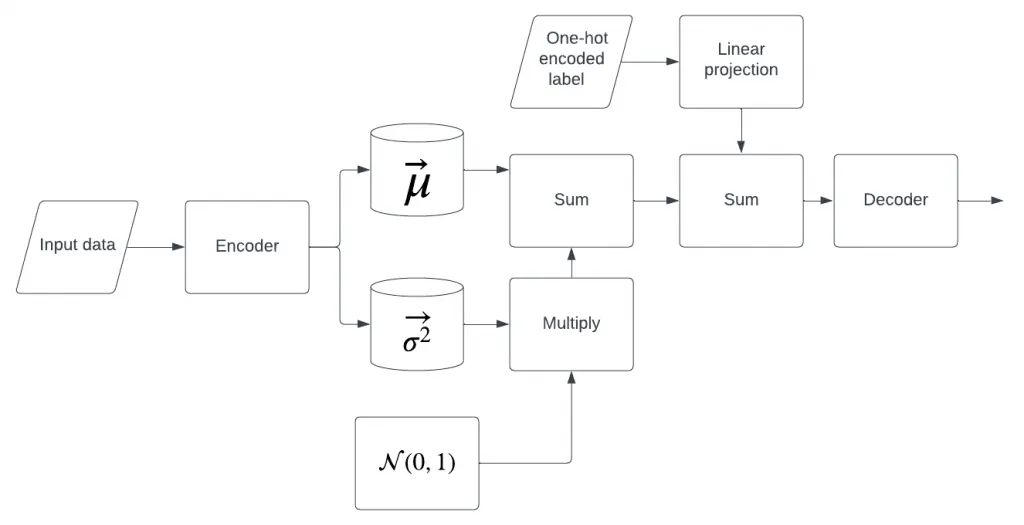\
[Source](https://medium.com/@sofeikov/implementing-conditional-variational-auto-encoders-cvae-from-scratch-29fcbb8cb08f)
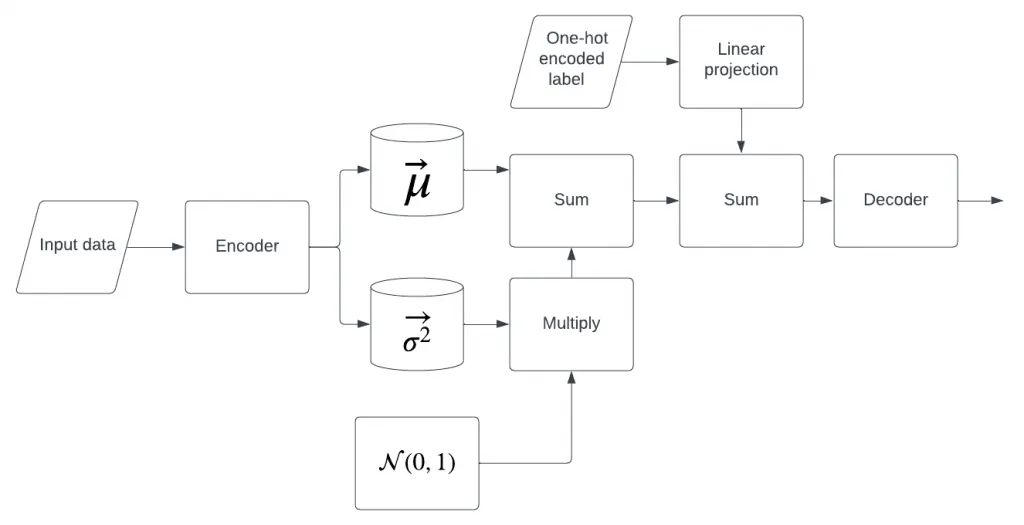

## Loss Function

The C-VAE uses a combination of two loss components:
1. Reconstruction Loss:
    * Measures how well the generated image matches the input image.
    * Calculated using Mean Squared Error (MSE) between the input and reconstructed image:\
        $\mathcal{L}{\text{recon}} = \frac{1}{N} \sum_{i=1}^N \| x_i - \hat{x}_i \|^2$
        * This ensures the decoder learns to produce images close to the original input.
    
2. KL Divergence Loss:
    * Regularizes the latent space by making it align with a standard normal distribution ( \mathcal{N}(0, I) ).
    * The KL divergence is calculated as:\
        $\mathcal{L}_{\text{KL}} = -\frac{1}{2} \sum \left( 1 + \log(\sigma^2) - \mu^2 - \sigma^2 \right)$
        * This ensures the latent space is smooth and allows meaningful sampling.

### Total Loss:

The total loss is a weighted combination of the two:

$\mathcal{L} = \mathcal{L}{\text{recon}} + \beta \cdot \mathcal{L}{\text{KL}}$

Where  $\beta$  is a hyperparameter controlling the trade-off between reconstruction quality and latent space regularization.

This loss function encourages the model to generate realistic images while maintaining a well-structured latent space.

## Educational Journey
This project served as a valuable learning experience for me, and it aims to inspire others to dive into generative modeling. Here’s what I learned:
1. Building and Debugging Conditional VAE:
    * This was my first attempt at implementing a vision-based generative model.
	* I explored the theory of VAEs and successfully implemented a C-VAE for conditional generation.
2. Debugging Neural Networks:
    * Learned to debug models by monitoring gradient flow and understanding how each architectural change affected performance.
	* Conducted multiple experiments to identify bottlenecks and improve parts of the model.

## Why This Notebook?

This notebook is designed to be an educational guide for anyone starting with conditional generative models. It details my approach, experiments, and observations while solving the problem of generating breed-specific dog images. I hope the journey and insights shared here will serve as a torch for others navigating the world of generative modeling.

# Imports

In [1]:
import zipfile
from IPython.display import clear_output
import torch.optim as optim
from torch.utils.data import DataLoader
from pathlib import Path
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import torchvision.io as io
from torch.utils.data import Dataset
import random
from tqdm.notebook import tqdm
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision
from IPython.display import display

# Reading Input Files

In [2]:
def zip2dir(input_zip, output_dir):
    # Ensure the directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Open the zip file
    with zipfile.ZipFile(input_zip, 'r') as zip_ref:
        # Extract all files
        zip_ref.extractall(output_dir)

> Unzipping input files

In [3]:
annot_dir = "Annotation/"
all_dogs = "all-dogs/"

# zip2dir("data/generative-dog-images/Annotation.zip", "./")
# zip2dir("data/generative-dog-images/all-dogs.zip", "./")

> Reading input files directories

In [4]:
all_dogs_files = [Path(all_dogs+i) for i in os.listdir(all_dogs)]
annot_files = [file for file in Path(annot_dir).rglob("*") if file.is_file()]

print(f"all_dogs_files: {all_dogs_files[:5]}")
print(f"annot_files: {annot_files[:5]}")

all_dogs_files: [PosixPath('all-dogs/n02109961_16718.jpg'), PosixPath('all-dogs/n02113799_5009.jpg'), PosixPath('all-dogs/n02091032_6587.jpg'), PosixPath('all-dogs/n02106166_1429.jpg'), PosixPath('all-dogs/n02093754_2276.jpg')]
annot_files: [PosixPath('Annotation/n02097658-silky_terrier/n02097658_98'), PosixPath('Annotation/n02097658-silky_terrier/n02097658_2535'), PosixPath('Annotation/n02097658-silky_terrier/n02097658_271'), PosixPath('Annotation/n02097658-silky_terrier/n02097658_427'), PosixPath('Annotation/n02097658-silky_terrier/n02097658_4890')]


> Creating DataFrame

In [5]:
tmp_map = {i.name: str(i) for i in annot_files}
input_file_dict = {str(i): tmp_map[i.stem] for i in all_dogs_files}

In [6]:
data = []

for k,v in input_file_dict.items():
    # Load and parse the XML file
    tree = ET.parse(v)  # Replace 'file.xml' with the path to your file
    root = tree.getroot()
    
    # Extract metadata
    folder = root.find('folder').text
    filename = root.find('filename').text
    database = root.find('source/database').text
    size = root.find('size')
    width = size.find('width').text
    height = size.find('height').text
    depth = size.find('depth').text
    
    # Extract object details and add metadata for each object
    for obj in root.findall('object'):
        name = obj.find('name').text
        pose = obj.find('pose').text
        truncated = obj.find('truncated').text
        difficult = obj.find('difficult').text
        bndbox = obj.find('bndbox')
        xmin = bndbox.find('xmin').text
        ymin = bndbox.find('ymin').text
        xmax = bndbox.find('xmax').text
        ymax = bndbox.find('ymax').text
    
        # Add a row for each object
        data.append({
            "ImageDirectory": k,
            "AnnotationDirectory": v,
            'Folder': folder,
            'Filename': filename,
            'Database': database,
            'Width': width,
            'Height': height,
            'Depth': depth,
            'ObjectName': name,
            'Pose': pose,
            'Truncated': truncated,
            'Difficult': difficult,
            'XMin': xmin,
            'YMin': ymin,
            'XMax': xmax,
            'YMax': ymax
        })

# Create DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
df.head()

ImageDirectory  \
0  all-dogs/n02109961_16718.jpg   
1   all-dogs/n02113799_5009.jpg   
2   all-dogs/n02091032_6587.jpg   
3   all-dogs/n02106166_1429.jpg   
4   all-dogs/n02093754_2276.jpg   

                                 AnnotationDirectory    Folder  \
0    Annotation/n02109961-Eskimo_dog/n02109961_16718  02109961   
1  Annotation/n02113799-standard_poodle/n02113799...  02113799   
2  Annotation/n02091032-Italian_greyhound/n020910...  02091032   
3  Annotation/n02106166-Border_collie/n02106166_1429  02106166   
4  Annotation/n02093754-Border_terrier/n02093754_...  02093754   

          Filename           Database Width Height Depth         ObjectName  \
0  n02109961_16718  ImageNet database   300    420     3         Eskimo_dog   
1   n02113799_5009  ImageNet database   302    500     3    standard_poodle   
2   n02091032_6587  ImageNet database   358    500     3  Italian_greyhound   
3   n02106166_1429  ImageNet database   375    500     3      Border_collie   
4   n02093754_2276  ImageNet database   500    375     3     Border_terrier   

          Pose Truncated Difficult XMin YMin XMax YMax  
0  Unspecified         0         0   36   80  200  417  
1  Unspecified         0         0   35   40  248  486  
2  Unspecified         0         0   43   35  314  483  
3  Unspecified         0         0   40  151  335  461  
4  Unspecified         0         0   37    0  498  374

> Little EDA

In [7]:
# General info about the DataFrame
print(df.info())

# Summary statistics of numeric columns
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22125 entries, 0 to 22124
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ImageDirectory       22125 non-null  object
 1   AnnotationDirectory  22125 non-null  object
 2   Folder               22125 non-null  object
 3   Filename             22125 non-null  object
 4   Database             22125 non-null  object
 5   Width                22125 non-null  object
 6   Height               22125 non-null  object
 7   Depth                22125 non-null  object
 8   ObjectName           22125 non-null  object
 9   Pose                 22125 non-null  object
 10  Truncated            22125 non-null  object
 11  Difficult            22125 non-null  object
 12  XMin                 22125 non-null  object
 13  YMin                 22125 non-null  object
 14  XMax                 22125 non-null  object
 15  YMax                 22125 non-null  object
dtypes: o

In [8]:
# Check for missing values
print(df.isnull().sum())

# Find unique values in categorical columns
for col in ['Folder', 'Database', 'ObjectName', 'Pose']:
    print(f"Unique values in {col}: {df[col].unique()}")

ImageDirectory         0
AnnotationDirectory    0
Folder                 0
Filename               0
Database               0
Width                  0
Height                 0
Depth                  0
ObjectName             0
Pose                   0
Truncated              0
Difficult              0
XMin                   0
YMin                   0
XMax                   0
YMax                   0
dtype: int64
Unique values in Folder: ['02109961' '02113799' '02091032' '02106166' '02093754' '02107683'
 '02094114' '02088094' '02097130' '02095314' '02087046' '02110627'
 '02099712' '02088632' '02105251' '02085936' '02093991' '02104029'
 '02096051' '02111500' '02093859' '02112706' '02112137' '02110185'
 '02113186' '02098286' '02089078' '02105162' '02085782' '02107574'
 '02106662' '02097474' '02105641' '02106550' '02095889' '02096294'
 '02102480' '02102040' '02091467' '02101556' '02096585' '02109047'
 '02099849' '02093256' '02092339' '02097209' '02090379' '02112018'
 '02105056' '02086910' '%s

ObjectName
Afghan_hound          287
Maltese_dog           264
Irish_wolfhound       263
Leonberg              256
Scottish_deerhound    246
                     ... 
Sussex_spaniel        153
affenpinscher         153
groenendael           152
Pekinese              152
redbone               151
Name: count, Length: 120, dtype: int64


<Axes: title={'center': 'Object Name Distribution'}, xlabel='ObjectName'>

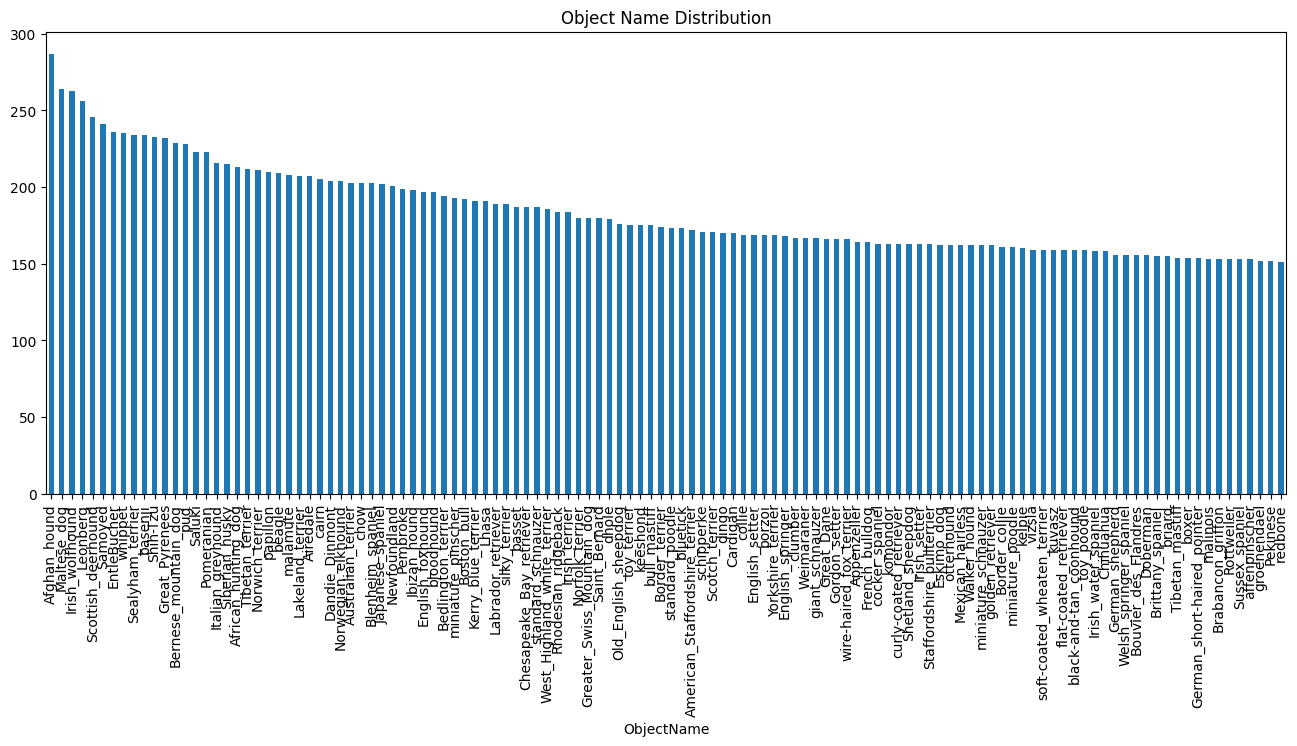

In [9]:
# Count occurrences of each object name
object_counts = df['ObjectName'].value_counts()
print(object_counts)

# Plot the distribution
object_counts.plot(kind='bar', title='Object Name Distribution', figsize=(16, 6))

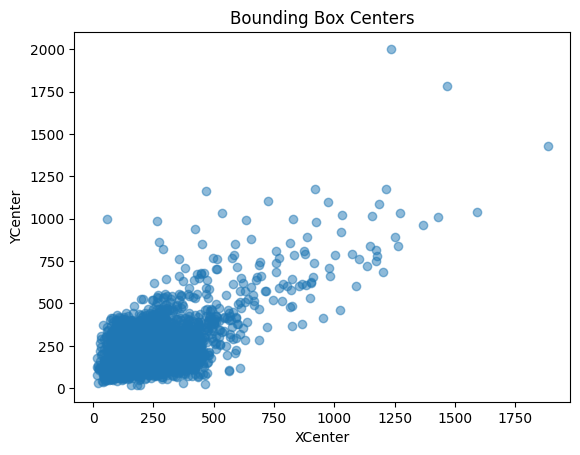

In [10]:
df['XCenter'] = (df['XMin'].astype(int) + df['XMax'].astype(int)) / 2
df['YCenter'] = (df['YMin'].astype(int) + df['YMax'].astype(int)) / 2

# Plot centers
plt.scatter(df['XCenter'], df['YCenter'], alpha=0.5)
plt.title('Bounding Box Centers')
plt.xlabel('XCenter')
plt.ylabel('YCenter')
plt.show()

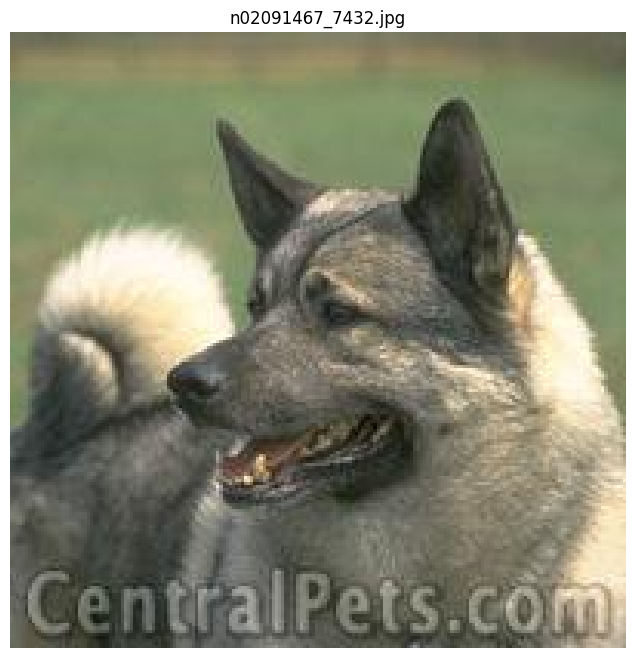

In [11]:
def denormalize(tensor, mean, std):
    """
    Denormalize a normalized tensor image back to the [0, 1] range for visualization.
    Args:
        tensor (torch.Tensor): The normalized image tensor.
        mean (list): Mean values used for normalization (per channel).
        std (list): Standard deviation values used for normalization (per channel).
    Returns:
        torch.Tensor: Denormalized image tensor in range [0, 1].
    """
    # Input validation
    if not isinstance(tensor, torch.Tensor):
        raise TypeError("Input must be a torch.Tensor")
    if tensor.dim() != 3:
        raise ValueError("Input must be a 3D tensor (C,H,W)")
        
    # Convert to float if needed
    tensor = tensor.float()
    
    # Reshape mean and std for broadcasting
    mean = torch.tensor(mean, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
    std = torch.tensor(std, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
    
    # Denormalize
    tensor = tensor * std + mean
    
    # Clamp values to [0, 1] range
    tensor = torch.clamp(tensor, 0, 1)
    
    return tensor

def show_image(image_path, denorm=False, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    """
    Display a single image given its path.
    Args:
        image_path (str): Path to the image file.
        denorm (bool): Whether to denormalize the image.
        mean (list): Mean values used for normalization.
        std (list): Standard deviation values used for normalization.
    """
    try:
        # Read image and convert to float
        img = io.read_image(image_path).float()
        
        # Normalize to [0, 1] range
        if img.max() > 1.0:
            img = img / 255.0
            
        # Apply denormalization if requested
        if denorm:
            img = denormalize(img, mean, std)
        
        # Convert to numpy and display
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        plt.title(image_path.split('/')[-1])
        plt.show()
        
    except Exception as e:
        print(f"Error: {e}")

# Example usage
random_image_path = df.sample().iloc[0]['ImageDirectory']
show_image(random_image_path)

## Analyzing BBoxes

In [12]:
# Assuming `df` is your DataFrame
df['XMin'] = pd.to_numeric(df['XMin'], errors='coerce')
df['XMax'] = pd.to_numeric(df['XMax'], errors='coerce')
df['YMin'] = pd.to_numeric(df['YMin'], errors='coerce')
df['YMax'] = pd.to_numeric(df['YMax'], errors='coerce')
df['BoundingBoxArea'] = (df['XMax'] - df['XMin']) * (df['YMax'] - df['YMin'])

In [13]:
df.to_csv("data.csv", index=False)

Bounding Box and Image Statistics:
        Bounding Box Widths  Bounding Box Heights  Image Widths  Image Heights
Min               17.000000             18.000000     97.000000     100.000000
Max             2735.000000           2025.000000   3264.000000    2562.000000
Mean             281.385763            290.686192    444.477424     384.812927
Median           270.000000            285.000000    500.000000     375.000000
StdDev           129.295807            120.695808    141.474519     123.639943


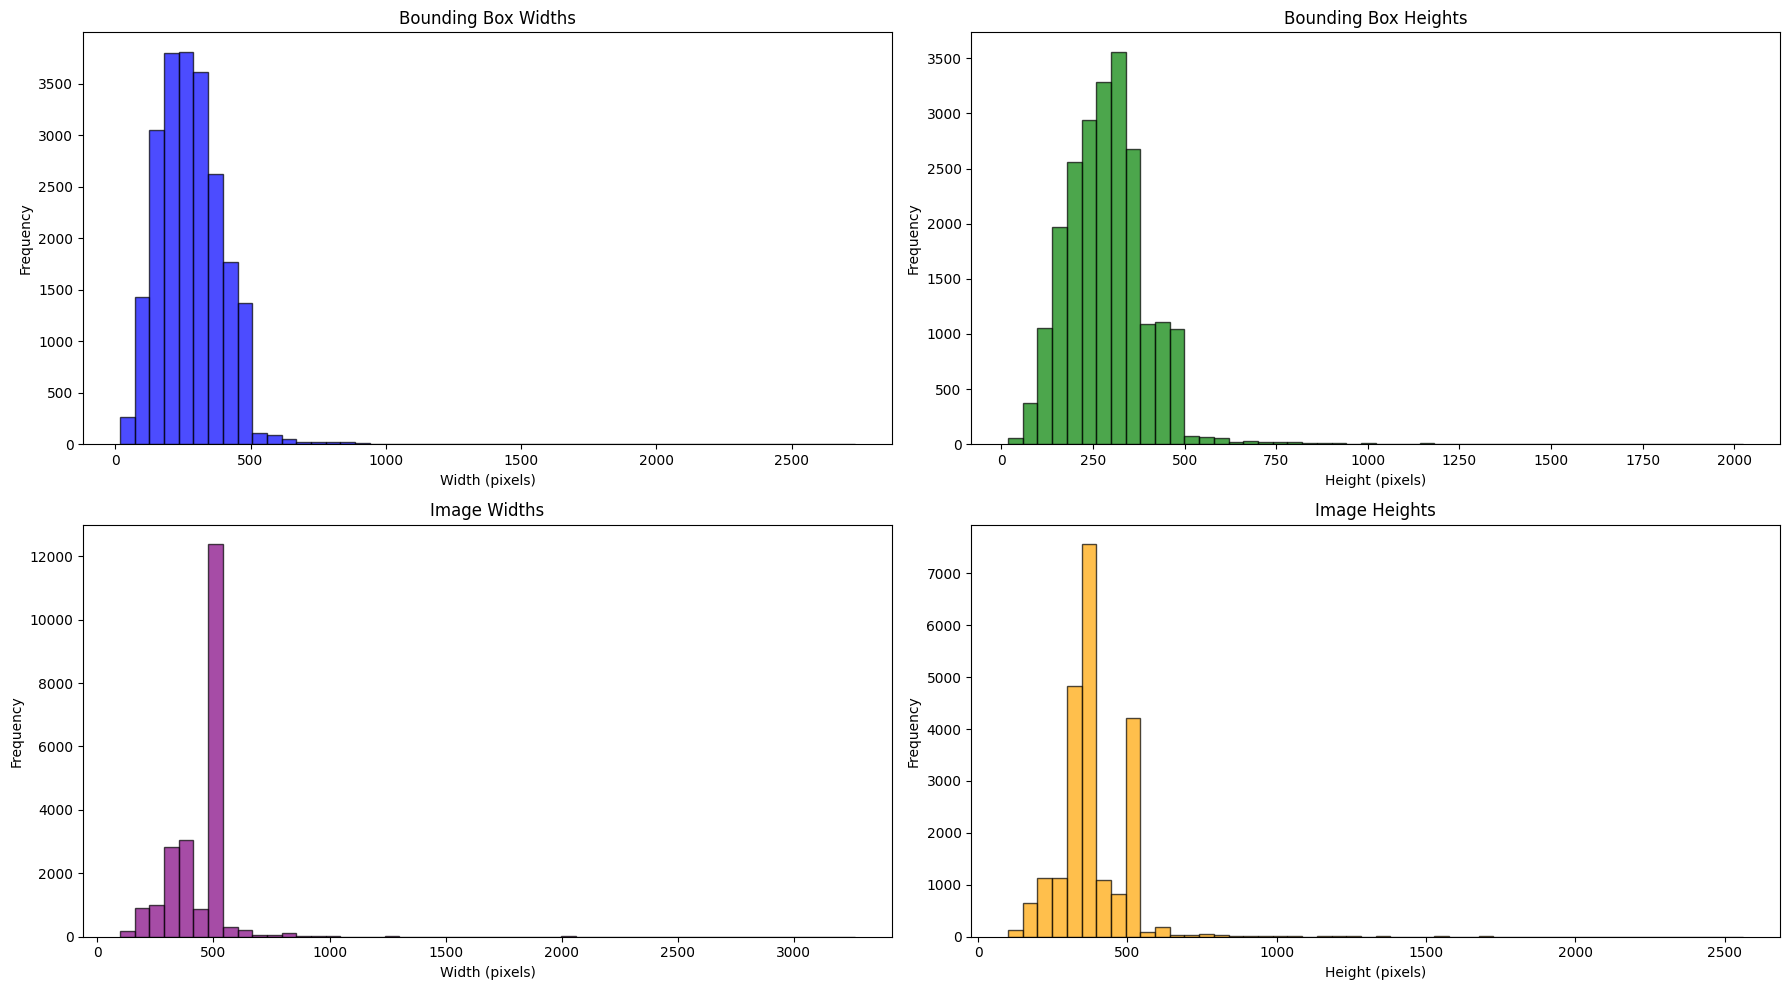

In [14]:
# Convert relevant columns to numeric types
columns_to_convert = ['XMax', 'XMin', 'YMax', 'YMin', 'BoundingBoxArea', 'Width', 'Height',]
for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Remove rows with invalid numeric data
bbox_data = df.dropna(subset=columns_to_convert)

# Extract bounding box dimensions
bbox_widths = bbox_data['XMax'] - bbox_data['XMin']
bbox_heights = bbox_data['YMax'] - bbox_data['YMin']
bbox_areas = bbox_data['BoundingBoxArea']
image_widths = bbox_data['Width']
image_heights = bbox_data['Height']

# Summarize statistics
summary = {
    "Bounding Box Widths": {
        "Min": bbox_widths.min(),
        "Max": bbox_widths.max(),
        "Mean": bbox_widths.mean(),
        "Median": bbox_widths.median(),
        "StdDev": bbox_widths.std()
    },
    "Bounding Box Heights": {
        "Min": bbox_heights.min(),
        "Max": bbox_heights.max(),
        "Mean": bbox_heights.mean(),
        "Median": bbox_heights.median(),
        "StdDev": bbox_heights.std()
    },
    "Image Widths": {
        "Min": image_widths.min(),
        "Max": image_widths.max(),
        "Mean": image_widths.mean(),
        "Median": image_widths.median(),
        "StdDev": image_widths.std()
    },
    "Image Heights": {
        "Min": image_heights.min(),
        "Max": image_heights.max(),
        "Mean": image_heights.mean(),
        "Median": image_heights.median(),
        "StdDev": image_heights.std()
    }
}

# Convert the summary to a DataFrame
summary_df = pd.DataFrame(summary)

# Display statistics
print("Bounding Box and Image Statistics:")
print(summary_df)

# Plot histograms for bounding boxes and image dimensions
plt.figure(figsize=(18, 10))

# Bounding box widths
plt.subplot(2, 2, 1)
plt.hist(bbox_widths, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('Bounding Box Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

# Bounding box heights
plt.subplot(2, 2, 2)
plt.hist(bbox_heights, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title('Bounding Box Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

# Image widths
plt.subplot(2, 2, 3)
plt.hist(image_widths, bins=50, alpha=0.7, color='purple', edgecolor='black')
plt.title('Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

# Image heights
plt.subplot(2, 2, 4)
plt.hist(image_heights, bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.title('Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Decision on Image Dimension Selection

After analyzing the statistics and distributions of bounding box widths, heights, and image dimensions, I have decided to standardize the image dimension to **256 pixels**. This decision is based on the following considerations:

1. **Divisibility by 2**: A dimension of 256 is divisible by 2 repeatedly, making it highly compatible with deep learning architectures that often involve downsampling operations.
2. **Ease of Handling**: 256 pixels is a manageable size that balances computational efficiency and sufficient detail retention for the task.
3. **Consistency**: Standardizing dimensions ensures uniformity in data preprocessing, improving the model's performance and interpretability.

This standardized dimension will be used for resizing all images before processing them further.

100%|██████████| 22125/22125 [08:51<00:00, 41.66it/s]


Processing complete! Data saved in 'image_paths.csv'.


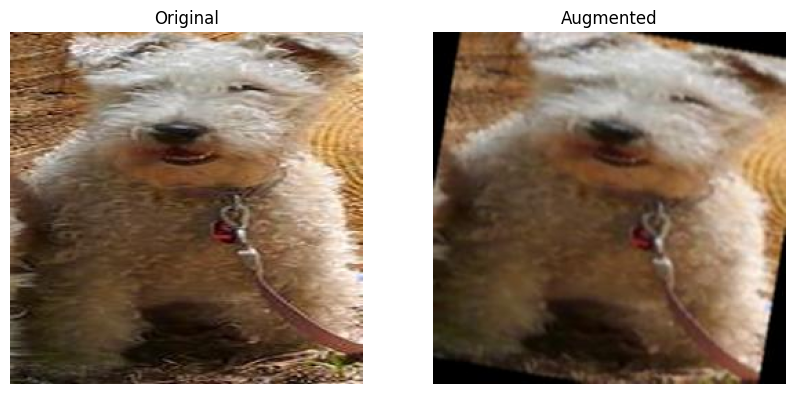

In [15]:
# Directories for saving images
os.makedirs("original_images", exist_ok=True)
os.makedirs("augmented_images", exist_ok=True)

# Define normalization parameters
MEAN = [0.5, 0.5, 0.5]
STD = [0.5, 0.5, 0.5]

# Transforms
crop_transform = transforms.Compose([
    transforms.Resize((256, 256))  # Crop and resize centered at BBox
])

augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.GaussianBlur(kernel_size=(3, 7), sigma=(0.1, 2.0)),  # Added blur
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)  # Apply normalization
])

def denormalize(tensor):
    """
    Denormalize a tensor image with fixed mean and std
    """
    tensor = tensor.clone()  # Avoid modifying the original tensor
    for t, m, s in zip(tensor, MEAN, STD):
        t.mul_(s).add_(m)
    return tensor.clamp_(0, 1)  # Clamp to [0,1] range

# DataFrame to store results
result = []
for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_path = row['ImageDirectory']
    object_name = row['ObjectName']
    x_center, y_center = row['XCenter'], row['YCenter']
    width, height = row['Width'], row['Height']
    bbox_width, bbox_height = row['XMax'] - row['XMin'], row['YMax'] - row['YMin']
    
    try:
        # Open and crop image
        img = Image.open(img_path).convert("RGB")
        left = max(0, x_center - bbox_width // 2)
        upper = max(0, y_center - bbox_height // 2)
        right = min(width, x_center + bbox_width // 2)
        lower = min(height, y_center + bbox_height // 2)
        cropped_img = img.crop((left, upper, right, lower)).resize((256, 256))
        
        # Save original cropped image
        original_path = f"original_images/{os.path.basename(img_path)}"
        cropped_img.save(original_path)
        
        # Apply augmentations
        aug_img = augment_transform(cropped_img)  # Returns normalized tensor
        
        # Denormalize before saving
        aug_img_denorm = denormalize(aug_img)
        
        # Convert to PIL and save
        aug_img_pil = transforms.ToPILImage()(aug_img_denorm)
        augmented_path = f"augmented_images/{os.path.basename(img_path)}"
        aug_img_pil.save(augmented_path)
        
        # Append to result DataFrame
        result.append({
            "OriginalImagePath": original_path,
            "AugmentedImagePath": augmented_path,
            "ObjectName": object_name
        })
        
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        continue

# Create DataFrame
final_df = pd.DataFrame(result)
final_df.to_csv("image_paths.csv", index=False)
print("Processing complete! Data saved in 'image_paths.csv'.")

# Function to view results
def view_pair(row_idx, final_df):
    """
    Display original and augmented image pair
    """
    import matplotlib.pyplot as plt
    
    row = final_df.iloc[row_idx]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display original
    img1 = Image.open(row['OriginalImagePath'])
    ax1.imshow(img1)
    ax1.set_title('Original')
    ax1.axis('off')
    
    # Display augmented
    img2 = Image.open(row['AugmentedImagePath'])
    ax2.imshow(img2)
    ax2.set_title('Augmented')
    ax2.axis('off')
    
    plt.show()

# View a random pair
random_idx = np.random.randint(len(final_df))
view_pair(random_idx, final_df)

In [16]:
final_df

OriginalImagePath  \
0      original_images/n02109961_16718.jpg   
1       original_images/n02113799_5009.jpg   
2       original_images/n02091032_6587.jpg   
3       original_images/n02106166_1429.jpg   
4       original_images/n02093754_2276.jpg   
...                                    ...   
22120   original_images/n02093991_4490.jpg   
22121   original_images/n02086910_6882.jpg   
22122   original_images/n02086910_6882.jpg   
22123   original_images/n02093256_6473.jpg   
22124   original_images/n02112137_6314.jpg   

                         AugmentedImagePath                 ObjectName  
0      augmented_images/n02109961_16718.jpg                 Eskimo_dog  
1       augmented_images/n02113799_5009.jpg            standard_poodle  
2       augmented_images/n02091032_6587.jpg          Italian_greyhound  
3       augmented_images/n02106166_1429.jpg              Border_collie  
4       augmented_images/n02093754_2276.jpg             Border_terrier  
...                                     ...                        ...  
22120   augmented_images/n02093991_4490.jpg              Irish_terrier  
22121   augmented_images/n02086910_6882.jpg                   papillon  
22122   augmented_images/n02086910_6882.jpg                   papillon  
22123   augmented_images/n02093256_6473.jpg  Staffordshire_bullterrier  
22124   augmented_images/n02112137_6314.jpg                       chow  

[22125 rows x 3 columns]

In [17]:
final_df.to_csv('final_df.csv', index=False)

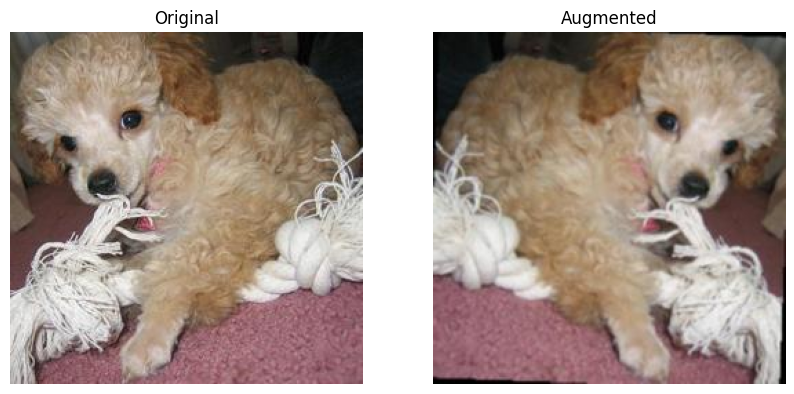

In [18]:
# View a random pair
random_idx = np.random.randint(len(final_df))
view_pair(random_idx, final_df)

# Conditional Variational Autoencoder (C-VAE)

The Conditional Variational Autoencoder (C-VAE) generates images conditioned on specific labels, such as dog breeds.

1. Encoder\
	•	Encodes input images into latent representations: mean (mu) and log-variance (logvar).\
	•	Uses convolutional layers, pooling, and residual connections for feature extraction.

2. Reparameterization \
    • Samples latent vector  z  as:
    $z = \mu + \epsilon \cdot \sigma \quad (\epsilon \sim \mathcal{N}(0, I))$
	• Enables stochastic sampling with backpropagation.

3. Conditioning\
	•	Dog breeds are mapped to embeddings, processed via a feedforward network, and concatenated with  z , enabling breed-specific generation.

4. Decoder\
	•	Reconstructs images from the conditioned  z  using upsampling, transposed convolutions, and residual connections.\
	•	A final Tanh activation normalizes outputs to [-1, 1].

5. Loss Function\
	•	Reconstruction Loss (MSE): Ensures generated images match inputs.\
	•	KL Divergence Loss: Regularizes the latent space to approximate a Gaussian distribution.\
$\mathcal{L} = \text{MSE} + \beta \cdot \text{KL Loss}$
6. Generation\
	•	Samples  z  from a Gaussian distribution, conditions it on a breed, and decodes to produce breed-specific images.

This structure efficiently combines latent space modeling with conditional embeddings for high-quality, breed-specific image generation.

In [39]:
class Encoder(nn.Module):
    def __init__(self, in_channels, feature_dim, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim


        # Initial convolution and pooling
        self.down_scale = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer_1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.SiLU(),
        )

        self.layer_2 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(256),
            nn.SiLU(),
        )

        self.layer_3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(512),
            nn.SiLU(),
        )

        self.layer_4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(512),
            nn.SiLU(),
        )

        self.layer_5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.SiLU(),
        )

        self.conv_final = nn.Conv2d(512, latent_dim * 2, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_final = nn.BatchNorm2d(latent_dim * 2)
        self.fact=nn.SiLU()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x3 = self.layer_3(x)
        x = self.layer_4(x3)
        x = self.fact(self.layer_5(x)+self.down_scale(x3))
        x = self.down_scale(x)
        x = self.conv_final(x)
        x = self.bn_final(x)
        x = self.fact(x)
        return x[:, :self.latent_dim, :, :], x[:, self.latent_dim:, :, :]

class Decoder(nn.Module):
    def __init__(self, in_channels, feature_dim, latent_dim):
        super(Decoder, self).__init__()
        self.in_channels = in_channels
        self.feature_dim = feature_dim
        self.latent_dim  = latent_dim

        # Upscaling layers with residual blocks
        self.up_scale = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.layer_1 = nn.Sequential(
                    nn.Conv2d(latent_dim, 512, kernel_size=7, stride=1, padding=3),
                    nn.BatchNorm2d(512),
                    nn.SiLU(),
                )

        self.layer_3 = nn.Sequential(
                    nn.Conv2d(512, 256, kernel_size=7, stride=1, padding=3),
                    nn.BatchNorm2d(256),
                    nn.SiLU(),
                )
        self.layer_4 = nn.Sequential(
                    nn.Conv2d(256, 64, kernel_size=5, stride=1, padding=2),
                    nn.BatchNorm2d(64),
                    nn.SiLU(),
                )
                
        self.layer_5 = nn.Sequential(
                    nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(64),
                    nn.SiLU(),
                )
        # Final convolution layer
        self.final_layer = nn.Sequential(
            nn.Conv2d(64, self.in_channels, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(self.in_channels),
            nn.Tanh()  # Outputs in range [-1, 1]
        )
        self.fact=nn.SiLU()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.up_scale(x)
        x = self.up_scale(x)
        x = self.layer_3(x)
        x = self.up_scale(x)
        x = self.layer_4(x)
        x = self.up_scale(x)
        x = self.fact(self.layer_5(x)+x)
        x = self.up_scale(x)
        x = self.final_layer(x) 
        return x

class VAE(nn.Module):
    def __init__(self, in_channels, feature_dim, latent_dim, cond_dim, n_conditions):
        super(VAE, self).__init__()
        self.in_channels = in_channels
        self.feature_dim = feature_dim
        self.latent_dim  = latent_dim
        self.encoder = Encoder(in_channels, feature_dim, latent_dim)
        self.decoder = Decoder(in_channels, feature_dim, latent_dim + cond_dim)
        self.n_conditions = n_conditions

        # Learnable embeddings for conditions
        self.condition_embeddings = nn.Embedding(n_conditions, cond_dim)
        self.condition_ffn = nn.Linear(cond_dim, cond_dim)
        self.tanh = nn.Tanh()

    def add_cond_emb(self, z, condition):
        # Add condition embedding
        cond_embedding = self.condition_ffn(self.condition_embeddings(condition).squeeze())
        cond_embedding = self.tanh(cond_embedding)
        cond_embedding = cond_embedding.unsqueeze(-1).unsqueeze(-1) # (batch_size, 1, cond_dim, 1, 1)
        if len(cond_embedding.shape) == 3: cond_embedding = cond_embedding.unsqueeze(0)
        cond_embedding = cond_embedding.expand(-1, -1, 8, 8)  # Expand for concatenation

        z_cond = torch.cat([z, cond_embedding], dim=1)
        return z_cond

    def reparameterize(self, mu, logvar, condition):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std

        return self.add_cond_emb(z, condition)

    def forward(self, x, condition):
        mu, logvar = self.encoder(x)
        # Reparametrizing trick
        z = self.reparameterize(mu, logvar, condition)

        # Decode
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        mse_loss = 0

        mse_loss += F.mse_loss(recon_x.view(-1, self.in_channels * self.feature_dim * self.feature_dim),
                               x.view(-1, self.in_channels * self.feature_dim * self.feature_dim))
        mse_loss /= len(recon_x)

        kl_loss = 0.5 * torch.mean(-1 - logvar + mu.pow(2) + logvar.exp())

        return mse_loss, kl_loss

    def generate(self, batch_size, condition=None, device="cuda"):
        """
        Generates images from random latents (and optional condition).
        """
        # 1) Sample random latent
        z = torch.randn(batch_size, self.latent_dim, 8, 8, device=device)

        # 2) Add condition embedding if you want conditional generation
        if condition is None:
            condition = torch.randint(0, self.n_conditions, (batch_size,), device=device)

        z = self.add_cond_emb(z, condition)

        # 3) Decode
        fake = self.decoder(z)
        return fake

In [36]:
model = VAE(3, 256, 256, 16, 120)
print(f"VAE has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} Trainable Parameters")
print(f"VAE Encoder has {sum(p.numel() for p in model.encoder.parameters() if p.requires_grad):,} Trainable Parameters")
print(f"VAE Decoder has {sum(p.numel() for p in model.decoder.parameters() if p.requires_grad):,} Trainable Parameters")
print(model.forward(torch.rand(2, 3, 256, 256), torch.tensor([[1], [5]]))[0].shape)
print(model.generate(5,device='cpu').shape)

VAE has 29,067,347 Trainable Parameters
VAE Encoder has 15,367,808 Trainable Parameters
VAE Decoder has 13,697,347 Trainable Parameters
torch.Size([2, 3, 256, 256])
torch.Size([5, 3, 256, 256])


In [37]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None, include_augmented=False):
        """
        Args:
            df: DataFrame with image paths and conditions (ObjectName)
            transform: Optional transforms to apply
            include_augmented: Whether to include augmented images
        """
        # Handle original and augmented data
        self.image_paths = df['OriginalImagePath'].tolist()
        self.aug_image_paths = df['AugmentedImagePath'].tolist()
        self.conditions = df['ObjectName'].tolist()
        self.include_augmented = include_augmented
        self.transform = transform

        # Load all images into memory
        self.orig_images = [self.transform(Image.open(p).convert('RGB')) if self.transform else Image.open(p).convert('RGB') for p in tqdm(self.image_paths)]
        self.aug_images = [self.transform(Image.open(p).convert('RGB')) if self.transform else Image.open(p).convert('RGB') for p in tqdm(self.aug_image_paths)]

        # Create condition encoder
        unique_conditions = sorted(set(self.conditions))
        self.condition_to_idx = {cond: idx for idx, cond in enumerate(unique_conditions)}
        self.num_conditions = len(unique_conditions)
        

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Select image based on augmentation inclusion
        if self.include_augmented:
            aug = random.random() < 0.2
            image = self.aug_images[idx] if aug else self.orig_images[idx]
        else:
            image = self.orig_images[idx]

        # Target image is the original image
        target_image = self.orig_images[idx]

        # Get condition
        condition = self.conditions[idx]
        condition_idx = self.condition_to_idx[condition]
        

        return image, torch.tensor(condition_idx, dtype=torch.long), target_image

In [21]:
def prepare_data(csv_path, batch_size=32):
    # Read the CSV
    df = pd.read_csv(csv_path)
    
    # Create train/val split (80/20)
    train_size = int(0.8 * len(df))
    train_df = df.iloc[:train_size]
    val_df = df.iloc[train_size:]
    
    # Define transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        # transforms.Resize((128, 128))
    ])
    
    # Create datasets
    train_dataset = CustomImageDataset(train_df, transform=transform, include_augmented=True)
    val_dataset = CustomImageDataset(val_df, transform=transform, include_augmented=False)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        pin_memory=True
    )
    
    return train_loader, val_loader, train_dataset.num_conditions

In [22]:
def plot_losses(train_losses, val_losses):
    """Plot training progress"""
    clear_output(wait=True)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    
    # Total loss
    ax1.plot([x['total'] for x in train_losses], label='Train')
    ax1.plot([x['total'] for x in val_losses], label='Val')
    ax1.set_title('Total Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    
    # Reconstruction loss
    ax2.plot([x['recon'] for x in train_losses], label='Train')
    ax2.plot([x['recon'] for x in val_losses], label='Val')
    ax2.set_title('Reconstruction Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    
    # KL loss
    ax3.plot([x['kl'] for x in train_losses], label='Train')
    ax3.plot([x['kl'] for x in val_losses], label='Val')
    ax3.set_title('KL Loss')
    ax3.set_xlabel('Epoch')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

def plot_gradients(model):
    encoder_grads = []
    decoder_grads = []

    # Collect gradients for encoder and decoder separately
    for name, param in model.named_parameters():
        if param.grad is not None:
            if name.startswith("encoder"):
                encoder_grads.append(param.grad.abs().mean().item())
            elif name.startswith("decoder"):
                decoder_grads.append(param.grad.abs().mean().item())

    # Combine x-axis positions for encoder and decoder
    total_layers = list(range(len(encoder_grads) + len(decoder_grads)))
    encoder_layers = total_layers[:len(encoder_grads)]
    decoder_layers = total_layers[len(encoder_grads):]

    # Plot gradients with a continuous x-axis
    plt.plot(encoder_layers, encoder_grads, label='Encoder Gradients', color='blue')
    plt.plot(decoder_layers, decoder_grads, label='Decoder Gradients', color='orange')
    plt.title('Gradient Magnitude (Encoder to Decoder Continuity)')
    plt.xlabel('Layer')
    plt.ylabel('Gradient Magnitude')
    plt.legend()
    plt.show()

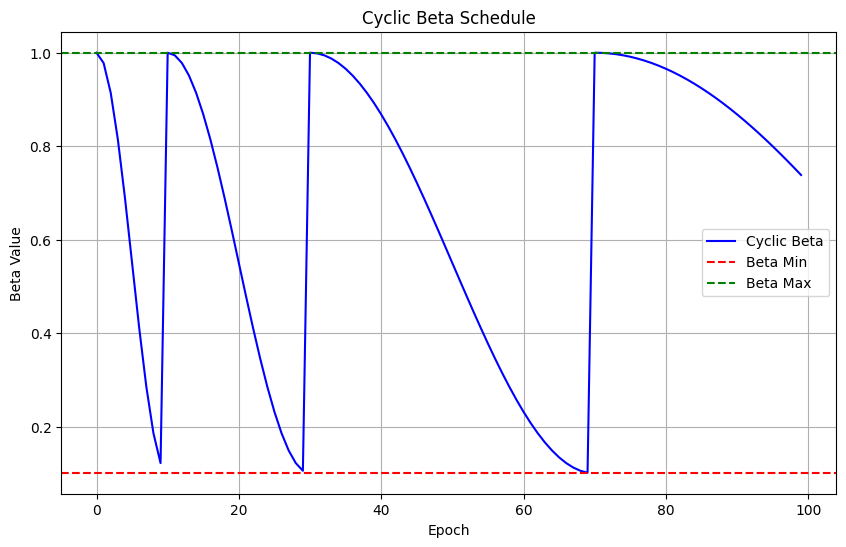

In [23]:
def get_cyclic_beta(epoch, T_0, T_mult=2, beta_min=0.1, beta_max=1.0):
    """
    Compute cyclic beta based on epoch, similar to a cosine annealing schedule.
    
    Args:
        epoch (int): Current epoch.
        T_0 (int): Number of epochs for the first cycle.
        T_mult (int): Cycle multiplier for successive cycles.
        beta_min (float): Minimum value of beta.
        beta_max (float): Maximum value of beta.

    Returns:
        beta (float): Beta value for the current epoch.
    """
    cycle_length = T_0
    while epoch >= cycle_length:
        epoch -= cycle_length
        cycle_length *= T_mult
    beta = beta_min + 0.5 * (beta_max - beta_min) * (1 + torch.cos(torch.tensor(epoch / cycle_length * 3.1415926535)))
    return beta.item()

# Scheduler parameters
T_0 = 10   # Number of epochs in the first cycle
T_mult = 2 # Cycle length multiplier
beta_min = 0.1
beta_max = 1.0
epochs = 100  # Total number of epochs to plot

# Compute beta values for all epochs
beta_values = [get_cyclic_beta(epoch, T_0, T_mult, beta_min, beta_max) for epoch in range(epochs)]

# Plot the cyclic beta values
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), beta_values, label="Cyclic Beta", color="blue")
plt.axhline(beta_min, color="red", linestyle="--", label="Beta Min")
plt.axhline(beta_max, color="green", linestyle="--", label="Beta Max")
plt.xlabel("Epoch")
plt.ylabel("Beta Value")
plt.title("Cyclic Beta Schedule")
plt.legend()
plt.grid()
plt.show()

In [61]:
MEAN = [0.5, 0.5, 0.5]
STD = [0.5, 0.5, 0.5]
def denormalize(tensor):
    """
    Denormalize a tensor image with fixed mean and std
    """
    tensor = tensor.clone()  # Avoid modifying the original tensor
    for t, m, s in zip(tensor, MEAN, STD):
        t.mul_(s).add_(m)
    return tensor.clamp_(0, 1)  # Clamp to [0,1] range

    
def train_vae(model, train_loader, val_loader, epochs=100, device='cuda', n_conditions=120):
    # Scheduler parameters
    T_0 = epochs   # Number of epochs in the first cycle
    T_mult = 2 # Cycle length multiplier
    beta_min = 0.01
    beta_max = 0.05
    
    # Loss function
    reconstruction_loss = nn.MSELoss()
    avg_val_loss = 0
    avg_val_recon = 0
    avg_val_kl = 0
    # Optimizer with adjusted learning rate
    optimizer = optim.AdamW(model.parameters(), lr=1e-4,)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-7)
    
    # Move model to device
    model = model.to(device)
    
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    fixed_z = torch.randn(1, model.latent_dim, 4, 4).to(device)
    fixed_cond = torch.randint(0, n_conditions, (1,1,)).to(device)
    val_iter = iter(val_loader)
    train_iter = iter(train_loader)
    val_samples, val_conditions, val_targets = next(val_iter)
    train_samples, train_conditions, train_targets = next(train_iter)
    val_samples = val_samples[4:6].to(device)  # Pick first two images
    val_conditions = val_conditions[4:6].to(device)
    val_targets = val_targets[4:6].to(device)
    
    train_samples = train_samples[4:6].to(device)  # Pick first two images
    train_conditions = train_conditions[4:6].to(device)
    train_targets = train_targets[4:6].to(device)
    fixed_val_samples = (val_samples, val_conditions, val_targets)
    fixed_train_samples = (train_samples, train_conditions, train_targets)
    for epoch in tqdm(range(epochs), desc="Training Progress"):
        # Training phase
        model.train()
        train_loss = 0
        train_recon_loss = 0
        train_kl_loss = 0
        beta = get_cyclic_beta(epoch, T_0, T_mult, beta_min, beta_max)
        print("Current beta is:", beta)
        train_pbar = tqdm(train_loader, leave=False, desc=f'Training Epoch {epoch+1}')
        for batch_idx, (data, condition, target) in enumerate(train_pbar):
            data, condition, target = data.to(device), condition.to(device), target.to(device)
            batch_size = data.size(0)
            
            optimizer.zero_grad()
            
            # Forward pass
            recon_batch, mu, logvar = model(data, condition)
            
            recon_loss, kl_loss = model.loss_function(recon_batch, target, mu, logvar)
            
            loss = recon_loss + beta * kl_loss
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Accumulate losses
            train_loss += loss.item() * batch_size
            train_recon_loss += recon_loss.item() * batch_size
            train_kl_loss += kl_loss.item() * batch_size
            
            train_pbar.set_postfix({
                'loss': loss.item(),
                'recon': recon_loss.item(),
                'kl': kl_loss.item()
            })
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_recon_loss = 0
        val_kl_loss = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, leave=False, desc=f'Validation Epoch {epoch+1}')
            for data, condition, target in val_pbar:
                data, condition, target = data.to(device), condition.to(device), target.to(device)
                batch_size = data.size(0)
                
                recon_batch, mu, logvar = model.forward(data, condition)

                recon_loss, kl_loss = model.loss_function(recon_batch, target, mu, logvar)
                loss = recon_loss + beta * kl_loss
                
                val_loss += loss.item() * batch_size
                val_recon_loss += recon_loss.item() * batch_size
                val_kl_loss += kl_loss.item() * batch_size
                
                val_pbar.set_postfix({
                    'loss': loss.item(),
                    'recon': recon_loss.item(),
                    'kl': kl_loss.item()
                })
        
        scheduler.step()
        
        # Calculate average losses
        train_size = len(train_loader.dataset)
        val_size = len(val_loader.dataset)
        
        avg_train_loss = train_loss / train_size
        avg_train_recon = train_recon_loss / train_size
        avg_train_kl = train_kl_loss / train_size
        
        avg_val_loss = val_loss / val_size
        avg_val_recon = val_recon_loss / val_size
        avg_val_kl = val_kl_loss / val_size
        
        # Store losses for plotting
        train_losses.append({
            'total': avg_train_loss,
            'recon': avg_train_recon,
            'kl': avg_train_kl
        })
        val_losses.append({
            'total': avg_val_loss,
            'recon': avg_val_recon,
            'kl': avg_val_kl
        })
        
        if (epoch + 1) % 5 == 0:
            plot_losses(train_losses, val_losses)
            
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': best_val_loss,
                'condition_to_idx': train_loader.dataset.condition_to_idx  # Save mapping
            }, 'best_model.pth')
        
        print(f'Epoch {epoch+1}:')
        print(f'Train Loss: {avg_train_loss:.4f} (Recon: {avg_train_recon:.4f}, KL: {avg_train_kl:.4f})')
        print(f'Valid Loss: {avg_val_loss:.4f} (Recon: {avg_val_recon:.4f}, KL: {avg_val_kl:.4f})')
        print('-' * 50)
        with torch.no_grad():
            plt.figure(figsize=(20, 4))
            fake_images = model.generate(batch_size=2, device='cuda')
            fake_images = denormalize(fake_images)
            fake_images = fake_images.clamp(0, 1).cpu()
            for i in range(fake_images.size(0)):
                plt.subplot(2, fake_images.size(0), i + 1)
                plt.imshow(fake_images[i].permute(1, 2, 0))
                plt.axis("off")
                plt.title("Generated")
            plt.tight_layout()
            plt.show()

            # Unpack fixed validation samples
            val_samples, val_conditions, val_targets = fixed_val_samples
            train_samples, train_conditions, train_targets = fixed_train_samples
            
            # Forward pass through the model
            recon_batch, mu, logvar = model.forward(val_samples, val_conditions)
            recon_batch_t, mu_t, logvar_t = model.forward(train_samples, train_conditions)

            # Compute reconstruction loss
            recon_loss, kl_loss = model.loss_function(recon_batch, val_targets, mu, logvar)
            recon_loss_t, kl_loss_t = model.loss_function(recon_batch_t, train_targets, mu_t, logvar_t)

            # Total loss
            total_loss = recon_loss + kl_loss
            print("Reconstruction Loss:", recon_loss.item())
            print("KL Divergence Loss:", kl_loss.item())
            print("Total Loss:", total_loss.item())

            total_loss_t = recon_loss_t + kl_loss_t
            print("Train Reconstruction Loss:", recon_loss_t.item())
            print("Train KL Divergence Loss:", kl_loss_t.item())
            print("Train Total Loss:", total_loss_t.item())

        
            # Convert original and reconstructed images to numpy
            recon_batch = denormalize(recon_batch)
            val_targets = denormalize(val_targets)
            original_imgs = val_targets.clamp(0, 1).cpu().numpy().transpose(0, 2, 3, 1)
            reconstructed_imgs = recon_batch.clamp(0, 1).cpu().numpy().transpose(0, 2, 3, 1)

            recon_batch_t = denormalize(recon_batch_t)
            train_targets = denormalize(train_targets)
            original_imgs_t = train_targets.clamp(0, 1).cpu().numpy().transpose(0, 2, 3, 1)
            reconstructed_imgs_t = recon_batch_t.clamp(0, 1).cpu().numpy().transpose(0, 2, 3, 1)
            
            # Plot original and reconstructed images
            for i in range(2):  # Iterate over the two images
                plt.subplot(1, 3, i + 2)
                plt.imshow(reconstructed_imgs[i])
                plt.axis('off')
                plt.title(f'Reconstructed Image {i+1} (Epoch {epoch+1})')

            # Show all images
            plt.tight_layout()
            plt.show()

            # Optional: Display original images separately
            plt.figure(figsize=(10, 5))
            for i in range(2):
                plt.subplot(1, 2, i + 1)
                plt.imshow(original_imgs[i])
                plt.axis('off')
                plt.title(f'Original Image {i+1}')
            plt.tight_layout()
            plt.show()



            # Plot original and reconstructed images
            for i in range(2):  # Iterate over the two images
                plt.subplot(1, 3, i + 2)
                plt.imshow(reconstructed_imgs_t[i])
                plt.axis('off')
                plt.title(f'Reconstructed Train Image {i+1} (Epoch {epoch+1})')

            # Show all images
            plt.tight_layout()
            plt.show()

            # Optional: Display original images separately
            plt.figure(figsize=(10, 5))
            for i in range(2):
                plt.subplot(1, 2, i + 1)
                plt.imshow(original_imgs_t[i])
                plt.axis('off')
                plt.title(f'Original Train Image {i+1}')
            plt.tight_layout()
            plt.show()
            plot_gradients(model)
        
        
    print(f'Valid Loss: {avg_val_loss:.4f} (Recon: {avg_val_recon:.4f}, KL: {avg_val_kl:.4f})')
    print('-' * 50)
    plot_losses(train_losses, val_losses)
    return train_losses, val_losses

# Overfitting
> Overfit a single batch of only a few examples (e.g. as little as two). To do so we increase the capacity of our model (e.g. add layers or filters) and verify that we can reach the lowest achievable loss (e.g. zero). I also like to visualize in the same plot both the label and the prediction and ensure that they end up aligning perfectly once we reach the minimum loss. If they do not, there is a bug somewhere and we cannot continue to the next stage.¹<br>
**Andrej Karpathy. (Apr 25, 2019). A Recipe for Training Neural Networks**

In [8]:
train_loader, val_loader, n_conditions = prepare_data("final_df.csv", batch_size=128)

  0%|          | 0/17700 [00:00<?, ?it/s]

  0%|          | 0/17700 [00:00<?, ?it/s]

  0%|          | 0/4425 [00:00<?, ?it/s]

  0%|          | 0/4425 [00:00<?, ?it/s]

VAE has 24,675,923 Trainable Parameters
VAE Encoder has 14,187,648 Trainable Parameters
VAE Decoder has 10,486,083 Trainable Parameters


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 10/100, Recon Loss: 0.0019449216779321432, KL Loss: 0.05355978384613991, Total Loss: 0.004622911103069782
Target Image:


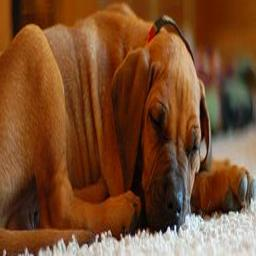

Reconstruction Image:


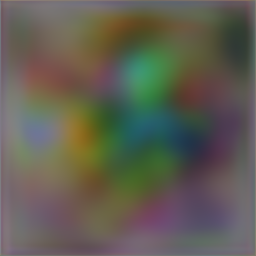

Target Image:


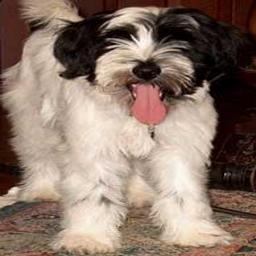

Reconstruction Image:


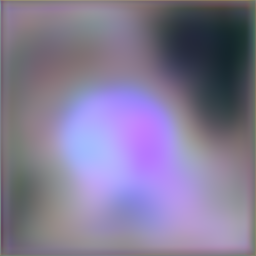

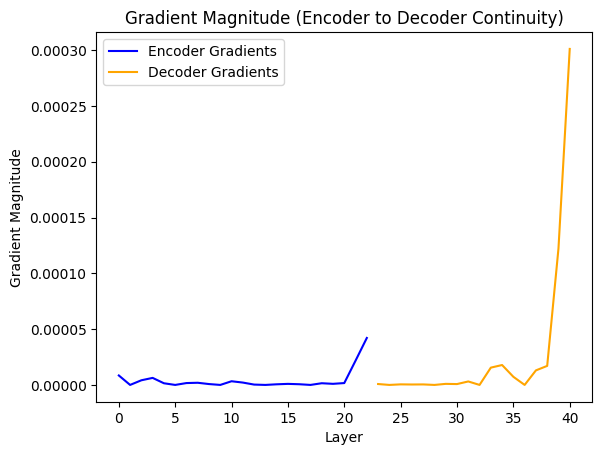

Epoch 20/100, Recon Loss: 0.0016197208315134048, KL Loss: 0.034628938883543015, Total Loss: 0.0033511677756905556
Target Image:


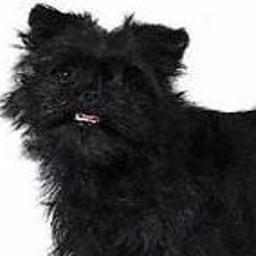

Reconstruction Image:


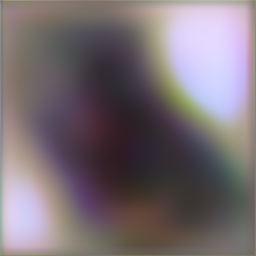

Target Image:


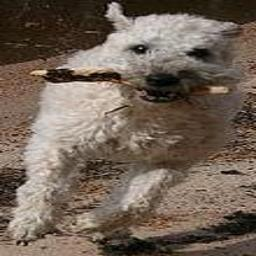

Reconstruction Image:


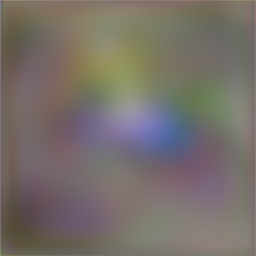

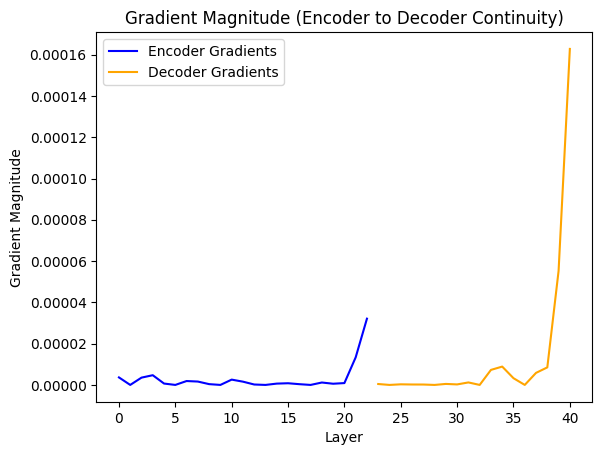

Epoch 30/100, Recon Loss: 0.0015056295087561011, KL Loss: 0.02263672649860382, Total Loss: 0.002637465950101614
Target Image:


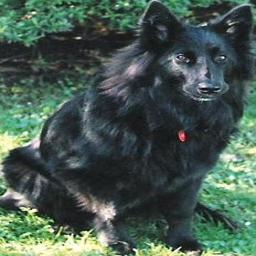

Reconstruction Image:


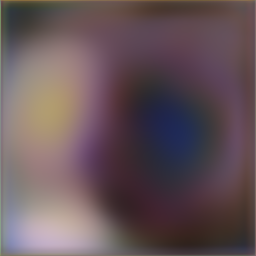

Target Image:


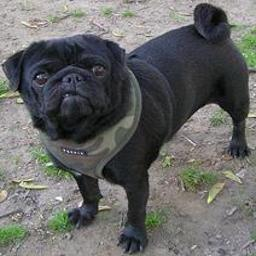

Reconstruction Image:


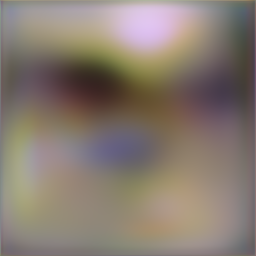

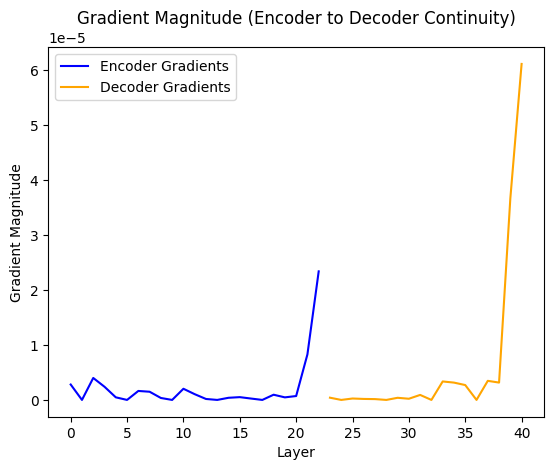

Epoch 40/100, Recon Loss: 0.001389844692312181, KL Loss: 0.015718702226877213, Total Loss: 0.0021757797803729773
Target Image:


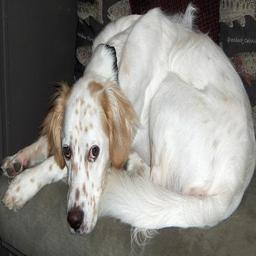

Reconstruction Image:


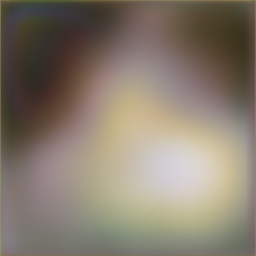

Target Image:


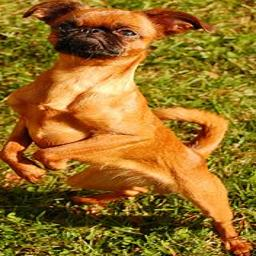

Reconstruction Image:


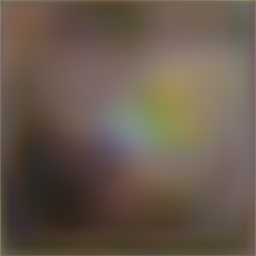

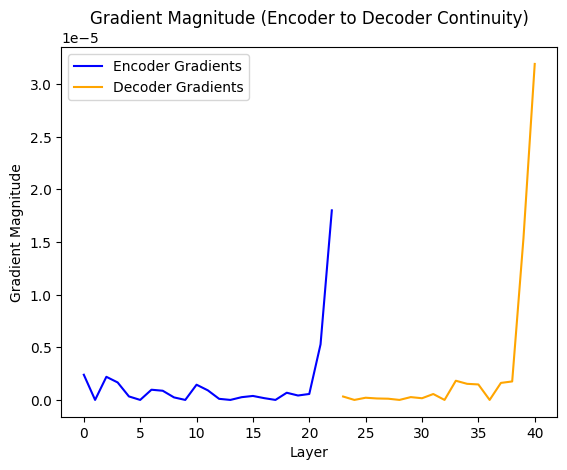

Epoch 50/100, Recon Loss: 0.0013665806036442518, KL Loss: 0.012002842500805855, Total Loss: 0.0019667227752506733
Target Image:


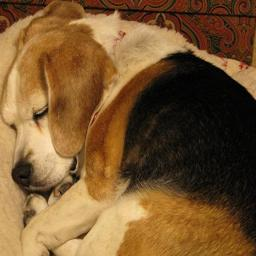

Reconstruction Image:


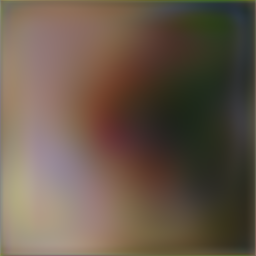

Target Image:


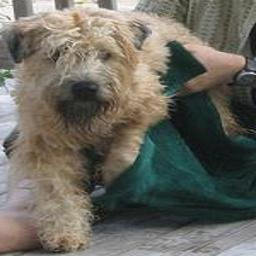

Reconstruction Image:


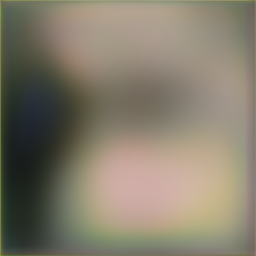

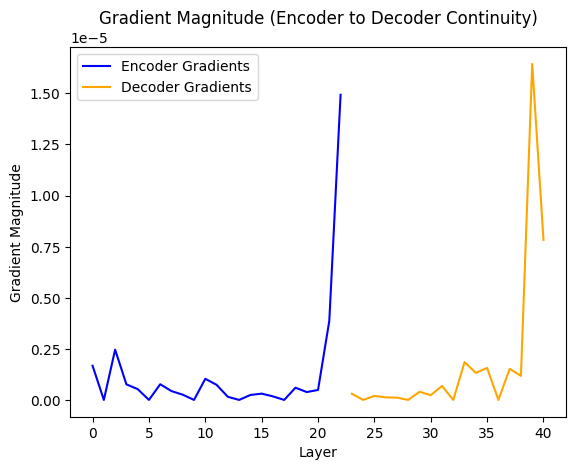

Epoch 60/100, Recon Loss: 0.0013525942340493202, KL Loss: 0.009062242694199085, Total Loss: 0.0018057064153254032
Target Image:


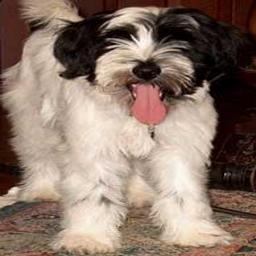

Reconstruction Image:


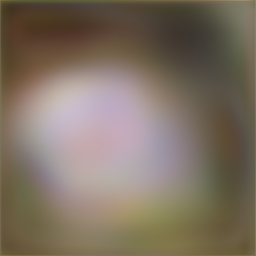

Target Image:


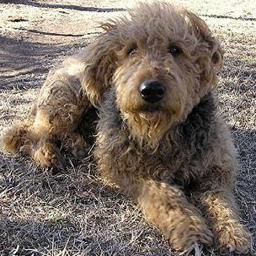

Reconstruction Image:


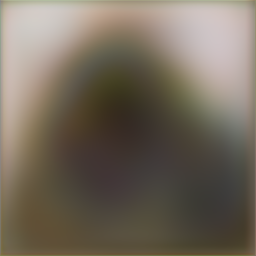

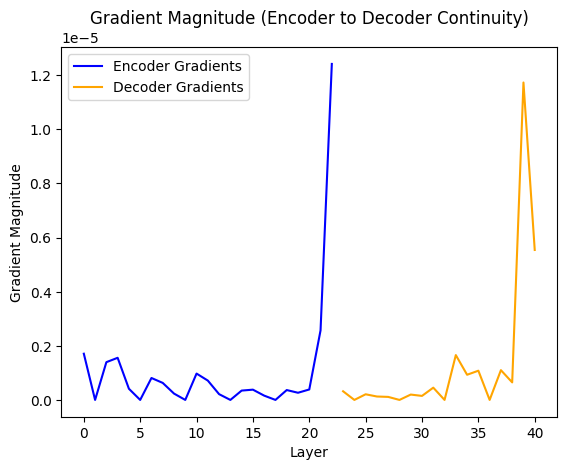

Epoch 70/100, Recon Loss: 0.0013220617547631264, KL Loss: 0.010845080949366093, Total Loss: 0.0018643158255144954
Target Image:


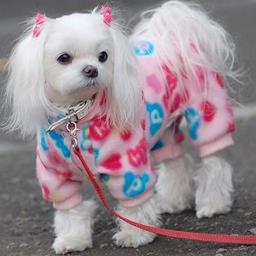

Reconstruction Image:


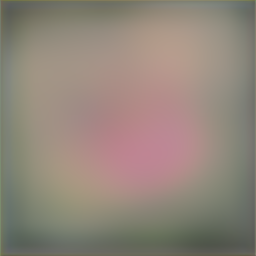

Target Image:


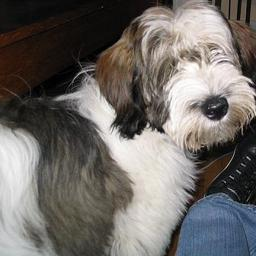

Reconstruction Image:


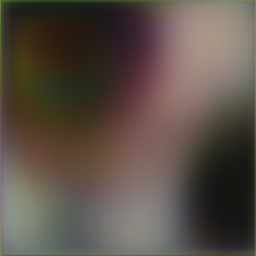

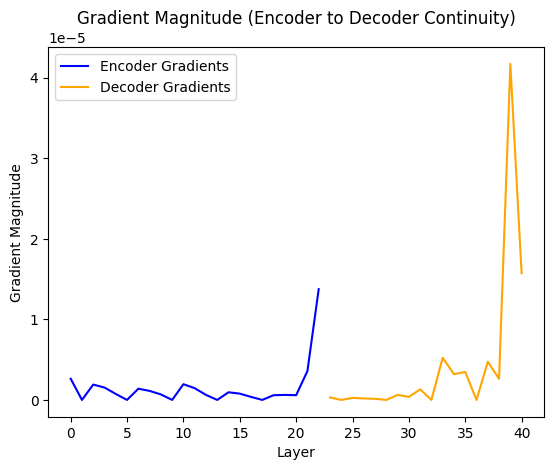

Epoch 80/100, Recon Loss: 0.0012931748060509562, KL Loss: 0.01160400826483965, Total Loss: 0.0018733751494437456
Target Image:


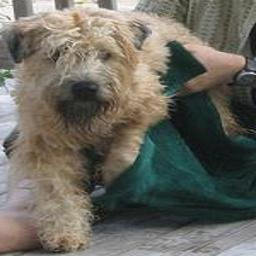

Reconstruction Image:


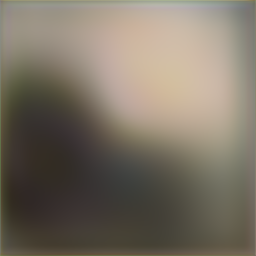

Target Image:


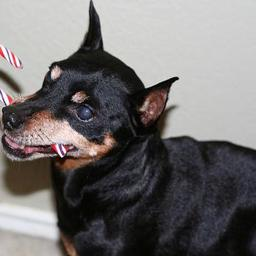

Reconstruction Image:


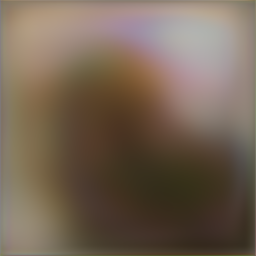

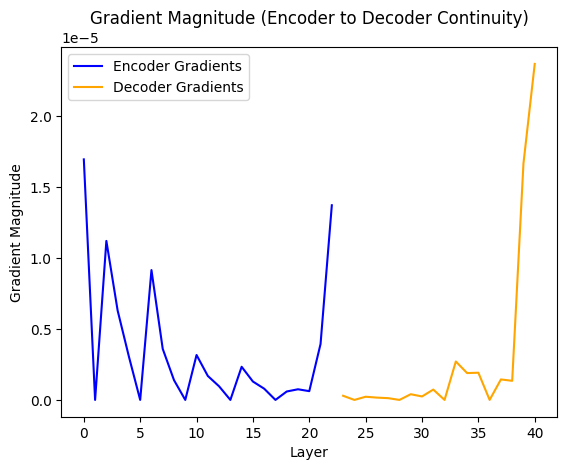

Epoch 90/100, Recon Loss: 0.0012265365803614259, KL Loss: 0.009309177286922932, Total Loss: 0.001691995421424508
Target Image:


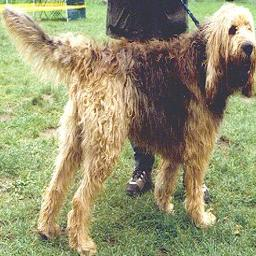

Reconstruction Image:


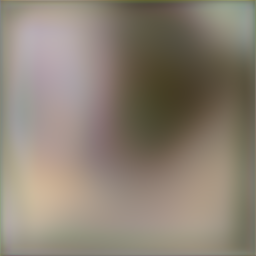

Target Image:


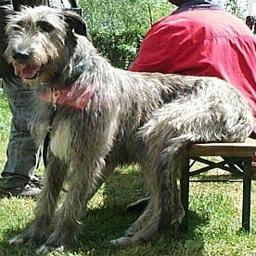

Reconstruction Image:


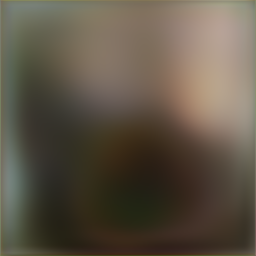

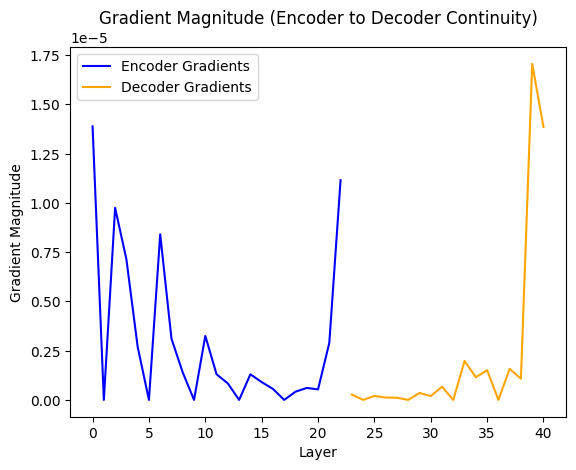

Epoch 100/100, Recon Loss: 0.0012538839364424348, KL Loss: 0.0067180488258600235, Total Loss: 0.001589786377735436
Target Image:


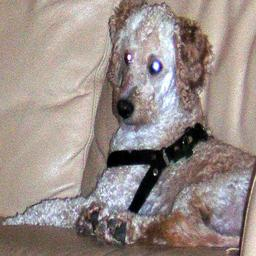

Reconstruction Image:


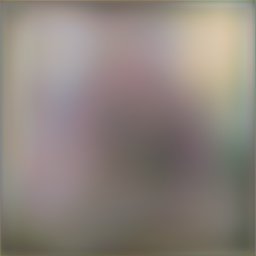

Target Image:


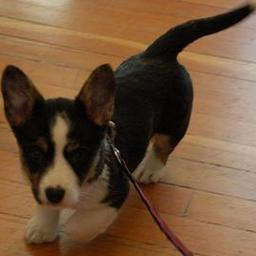

Reconstruction Image:


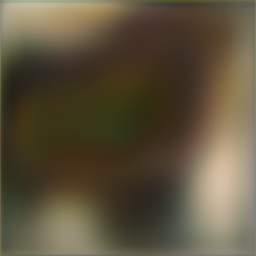

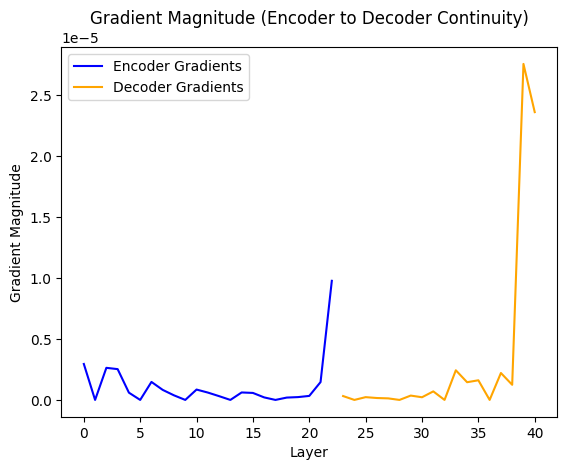

In [46]:
# Create a tiny dataset with 2 examples
tiny_loader = DataLoader(
    torch.utils.data.Subset(train_loader.dataset, [i+torch.randint(0, 10000, (1,)).item() for i in range(128)]),  # Use two examples
    batch_size=128,
    shuffle=True
)
# Adjust model capacity (optional, depends on results)
model = VAE(in_channels=3, feature_dim=256, latent_dim=128, cond_dim=16, n_conditions=n_conditions)
print(f"VAE has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} Trainable Parameters")
print(f"VAE Encoder has {sum(p.numel() for p in model.encoder.parameters() if p.requires_grad):,} Trainable Parameters")
print(f"VAE Decoder has {sum(p.numel() for p in model.decoder.parameters() if p.requires_grad):,} Trainable Parameters")
model = model.to('cuda')
feature_maps = {}
to_img = torchvision.transforms.ToPILImage()

def hook_fn(module, input, output):
    feature_maps[module] = output

# Register hooks for layers
for name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d):
        layer.register_forward_hook(hook_fn)
# Train on a single batch
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
epochs = 100
T_0 = 20   # Number of epochs in the first cycle
T_mult = 2 # Cycle length multiplier
beta_min = 0.001
beta_max = 1
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
for epoch in tqdm(range(epochs)):
    beta = 0.05#get_cyclic_beta(epoch, T_0, T_mult, beta_min, beta_max)
    
    model.train()
    for data, condition, target in tiny_loader:
        data, condition, target = data.to('cuda'), condition.to('cuda'), target.to('cuda')
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data, condition)
        recon_loss, kl_loss = model.loss_function(recon_batch, target, mu, logvar)

        loss = recon_loss + beta*kl_loss
        loss.backward()
        optimizer.step()

    # Visualize every 100 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Recon Loss: {recon_loss.item()}, KL Loss: {kl_loss.item()}, Total Loss: {loss.item()}")

        # Plot labels and predictions
        with torch.no_grad():
            
            for data, condition, target in tiny_loader:
                data, condition, target = data.to('cuda'), condition.to('cuda'), target.to('cuda')

            data = data[:2]
            condition = condition[:2]
            target = target[:2]

            recon_batch, mu, logvar = model.forward(data, condition)

            for i in range(data.size(0)):
                recon_batch_i = to_img(denormalize(recon_batch[i]))
                target_i = to_img(denormalize(target[i]))
                print("Target Image:")
                display(target_i)
                print("Reconstruction Image:")
                display(recon_batch_i)

        plot_gradients(model)


- Since loss is decreasing and reconstructions are normal, I think everything is good

# Model visualising
This section focuses on understanding what the model has learned and how it operates by analyzing its intermediate outputs and behaviors:\
1.	Generating Random Images: Generates new images from random latent vectors, optionally conditioned on specific labels (e.g., dog breeds).\
2.	Visualizing Layer Channels: Displays how the image transforms as it passes through the channels of each layer, highlighting the feature extraction process.\
3.	Inspecting mu and logvar Distributions: Plots the distributions of the latent mean (mu) and log-variance (logvar) within a batch, providing insights into the learned latent space.\
4.	Layer Activations: Examines the activations of each layer during forward passes to identify which features the model emphasizes.\
5.	Gradient Flow Analysis: Monitors gradient magnitudes across layers during training to detect anomalies such as vanishing or exploding gradients, ensuring stable learning dynamics.

This multi-faceted visualization approach provides a comprehensive understanding of the model’s learning process and potential areas for improvement.

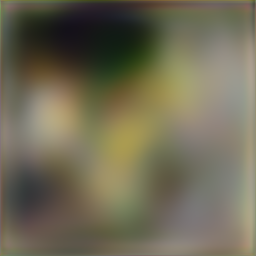

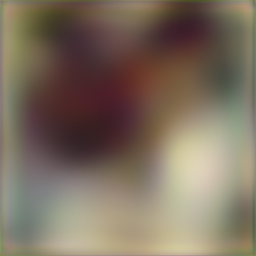

In [48]:
with torch.no_grad():
    fake_images = model.generate(batch_size=2, device='cuda')
    for i in range(fake_images.size(0)):
        display(to_img(denormalize(fake_images[i])))

In [49]:
# Run a batch through the model
data, condition = [(data.to('cpu'), condition.to('cpu')) for data, condition, target in tiny_loader][0]
model = model.to('cpu')
model.eval()
with torch.no_grad():
    _ = model(data, condition)


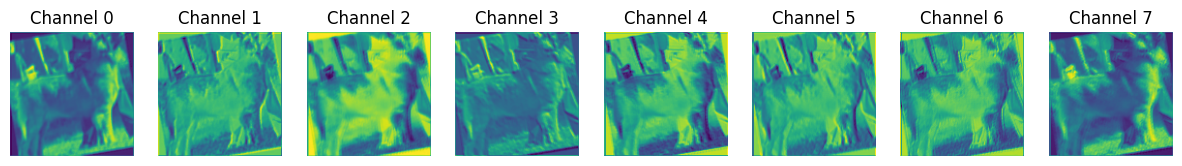

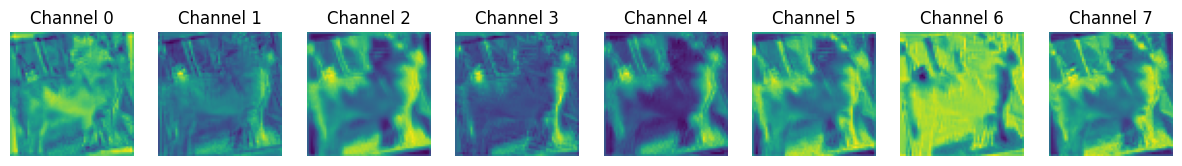

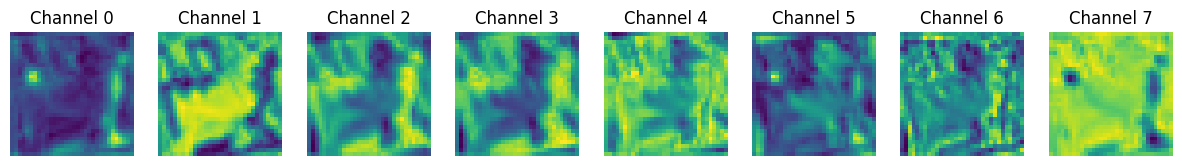

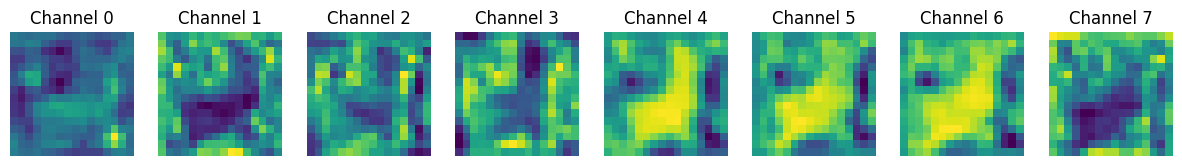

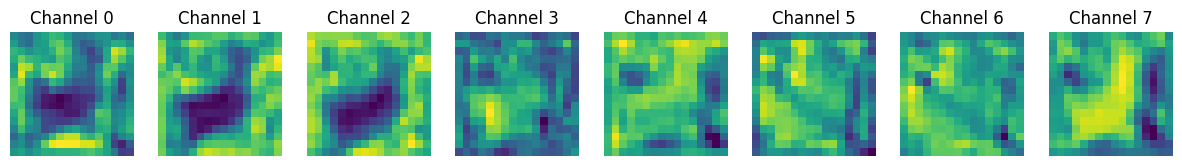

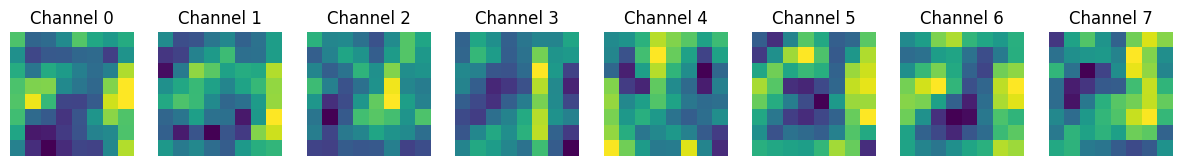

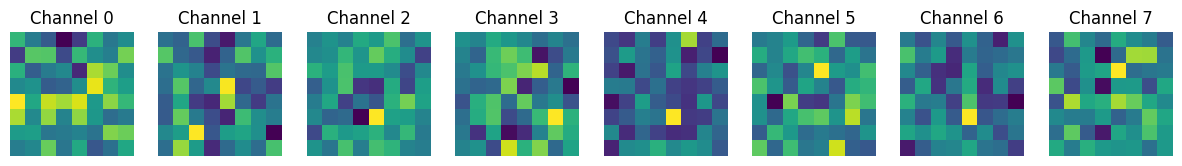

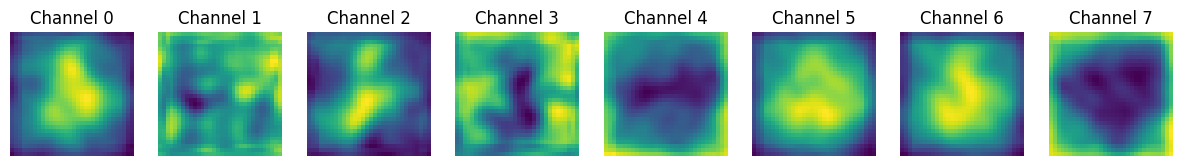

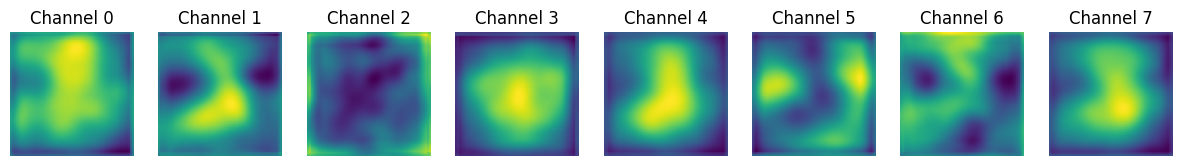

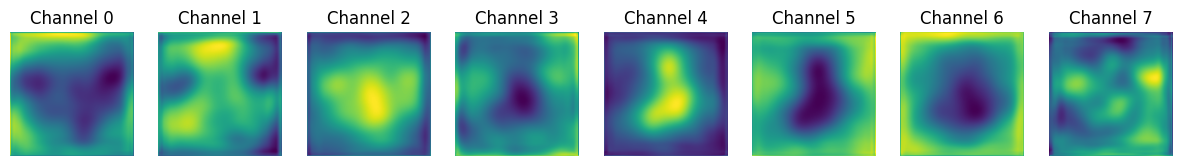

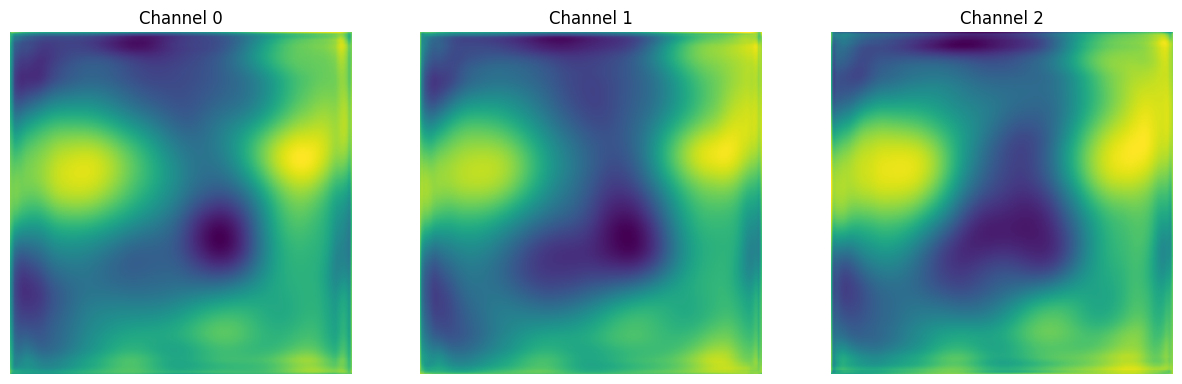

In [50]:
def visualize_feature_maps(feature_maps, num_channels=8):
    for layer_name in feature_maps:
        fmap = feature_maps[layer_name][0].detach().cpu().numpy()  # Batch index 0
        num_channels = min(num_channels, fmap.shape[0])
        fig, axes = plt.subplots(1, num_channels, figsize=(15, 5))
        for i in range(num_channels):
            axes[i].imshow(fmap[i], cmap='viridis')
            axes[i].axis('off')
            axes[i].set_title(f'Channel {i}')
        plt.show()
visualize_feature_maps(feature_maps)

torch.Size([128, 3, 256, 256])


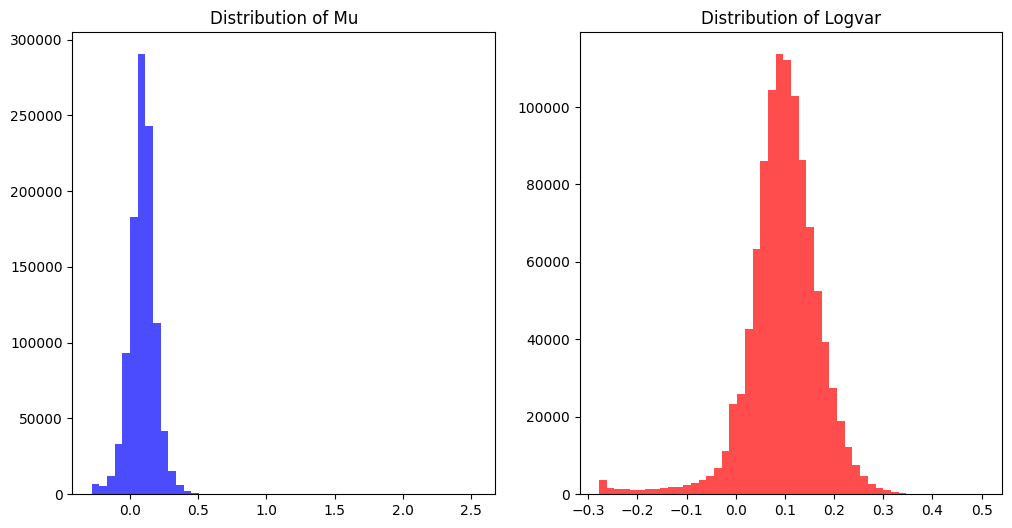

In [51]:
batch_img=[data for data, condition, target in tiny_loader][0].to('cpu')

print(batch_img.shape)
mu, logvar = model.encoder(batch_img)

# Plot histograms
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(mu.detach().cpu().numpy().flatten(), bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Mu")
plt.subplot(1, 2, 2)
plt.hist(logvar.detach().cpu().numpy().flatten(), bins=50, color='red', alpha=0.7)
plt.title("Distribution of Logvar")
plt.show()

In [52]:
# Dictionary to store activations
activations = {}

# Hook function to capture pre- and post-activation values
def hook_fn(module, input, output):
    activations[module] = {'input': input[0], 'output': output}

# Register hooks for layers of interest
hooks = []
for name, layer in model.named_modules():
    if isinstance(layer, (nn.Conv2d, nn.Linear, nn.BatchNorm2d)):
        hooks.append(layer.register_forward_hook(hook_fn))


# Run a batch through the model
data, condition = [(data.to('cpu'), condition.to('cpu')) for data, condition, target in tiny_loader][0]

model.eval()
with torch.no_grad():
    _ = model(data, condition)

# Print statistics for each layer
for module, act in activations.items():
    inp = act['input']
    out = act['output']
    print(f"Layer: {module}")
    print(f"Input - Mean: {inp.mean().item():.4f}, Std: {inp.std().item():.4f}, Min: {inp.min().item():.4f}, Max: {inp.max().item():.4f}")
    print(f"Output - Mean: {out.mean().item():.4f}, Std: {out.std().item():.4f}, Min: {out.min().item():.4f}, Max: {out.max().item():.4f}")
    print("-" * 50)

Layer: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
Input - Mean: -0.1631, Std: 0.5300, Min: -1.0000, Max: 1.0000
Output - Mean: 0.0101, Std: 0.3584, Min: -1.7886, Max: 1.8048
--------------------------------------------------
Layer: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Input - Mean: 0.0101, Std: 0.3584, Min: -1.7886, Max: 1.8048
Output - Mean: 0.0008, Std: 1.0049, Min: -9.4100, Max: 9.5876
--------------------------------------------------
Layer: Conv2d(64, 256, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
Input - Mean: 0.2129, Std: 0.5495, Min: -0.2785, Max: 9.5869
Output - Mean: -0.0365, Std: 0.9417, Min: -6.1851, Max: 4.3560
--------------------------------------------------
Layer: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Input - Mean: -0.0365, Std: 0.9417, Min: -6.1851, Max: 4.3560
Output - Mean: -0.0037, Std: 1.0223, Min: -8.8374, Max: 6.7026
------------------------------

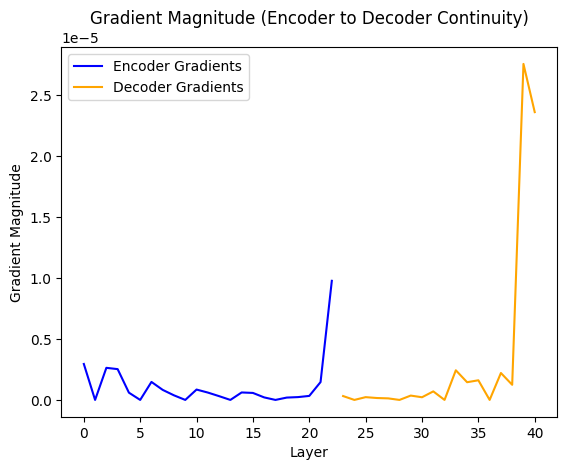

In [53]:
plot_gradients(model)

# Training

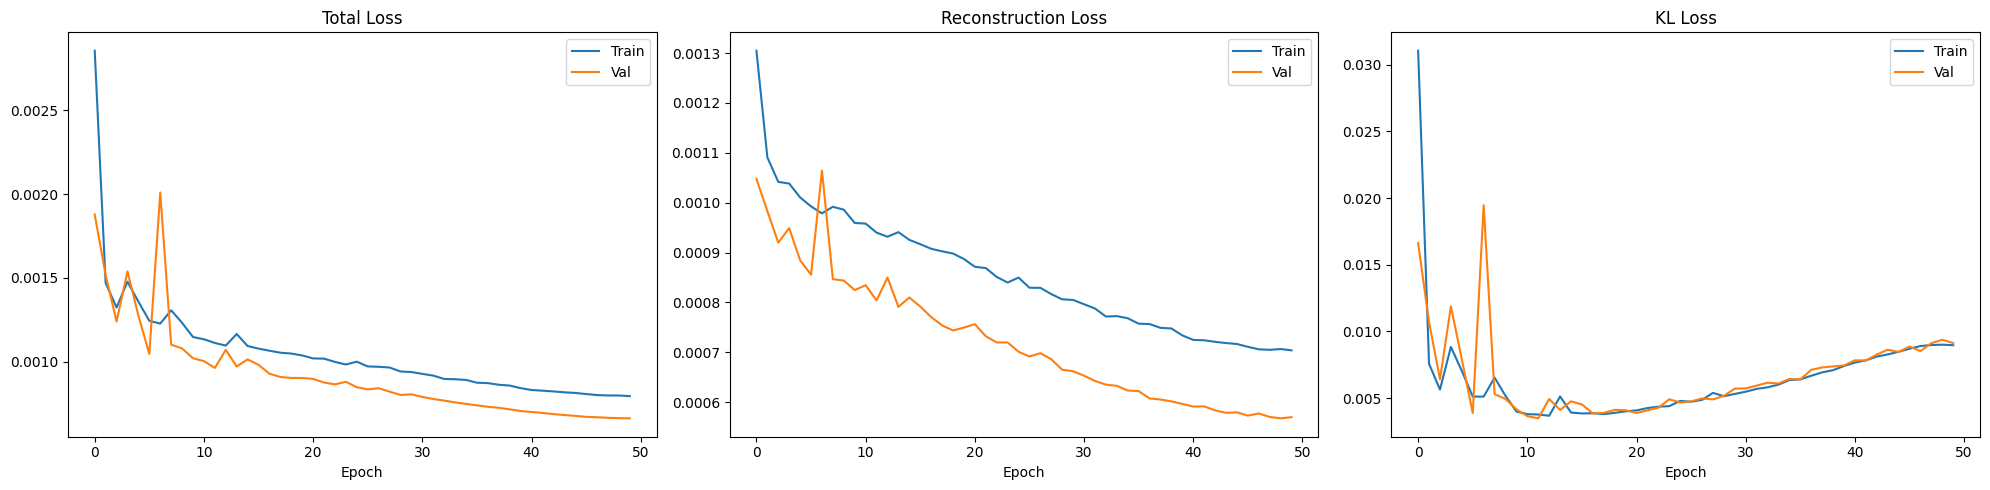

In [62]:
# Initialize data and model
model = VAE(in_channels=3, feature_dim=256, latent_dim=512, cond_dim=32, n_conditions=n_conditions)
print(f"VAE has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} Trainable Parameters")
# Train model and get loss history
train_losses, val_losses = train_vae(model, train_loader, val_loader, epochs=50, device='cuda', n_conditions=n_conditions)

# Inference
1. Loads best model
2. Generates random dog images

In [79]:
test_model = VAE(in_channels=3, feature_dim=256, latent_dim=512, cond_dim=32, n_conditions=n_conditions)
checkpoint = torch.load('best_model.pth')
test_model.load_state_dict(checkpoint['model_state_dict'])

/tmp/ipykernel_11116/2181008345.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


<All keys matched successfully>

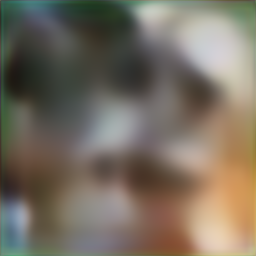

In [488]:
# Enter name of dog breeds (you can find them below)
conditions = ['Eskimo_dog']

conditions = torch.tensor([train_loader.dataset.condition_to_idx[i] for i in conditions])
to_img = torchvision.transforms.ToPILImage()
with torch.no_grad():
    fake_images = test_model.generate(batch_size=1, condition=conditions, device='cpu')
    for i in range(fake_images.size(0)):
        display(to_img(denormalize(fake_images[i])))

In [30]:
train_loader.dataset.conditions

['Eskimo_dog',
 'standard_poodle',
 'Italian_greyhound',
 'Border_collie',
 'Border_terrier',
 'Bernese_mountain_dog',
 'Norfolk_terrier',
 'Afghan_hound',
 'giant_schnauzer',
 'giant_schnauzer',
 'wire-haired_fox_terrier',
 'toy_terrier',
 'affenpinscher',
 'affenpinscher',
 'Labrador_retriever',
 'bluetick',
 'briard',
 'Maltese_dog',
 'Irish_terrier',
 'Irish_terrier',
 'kuvasz',
 'Italian_greyhound',
 'Italian_greyhound',
 'Border_collie',
 'Airedale',
 'Great_Pyrenees',
 'Kerry_blue_terrier',
 'toy_terrier',
 'Brabancon_griffon',
 'toy_terrier',
 'Irish_terrier',
 'Irish_terrier',
 'chow',
 'Siberian_husky',
 'Cardigan',
 'kuvasz',
 'West_Highland_white_terrier',
 'black-and-tan_coonhound',
 'Border_collie',
 'malinois',
 'Japanese_spaniel',
 'Greater_Swiss_Mountain_dog',
 'German_shepherd',
 'Tibetan_terrier',
 'Old_English_sheepdog',
 'Rottweiler',
 'Norfolk_terrier',
 'Great_Pyrenees',
 'Sealyham_terrier',
 'malinois',
 'Australian_terrier',
 'Afghan_hound',
 'Sussex_spaniel',


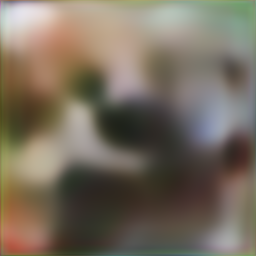

In [255]:
# Random Generator

to_img = torchvision.transforms.ToPILImage()
with torch.no_grad():
    fake_images = test_model.generate(batch_size=1,  device='cpu')
    for i in range(fake_images.size(0)):
        display(to_img(denormalize(fake_images[i])))

# Project Summary

I created a Conditional Variational Autoencoder (C-VAE) and trained it on a dog image dataset. The model’s performance was suboptimal, with poor structure in generated images. However, it demonstrated some understanding of key features like noses and colors of certain dog breeds.

Observations:\
• Performance Issues: Likely caused by limitations in both the dataset quality and model architecture.\
• Learning Outcome: The project served as an educational experiment, providing valuable insights into conditional VAEs and generative modeling techniques.